# Tango Patterns
## Forecasting Future Positions the Follow Dancer Given the Certain Past Positions of the Lead Dancer
### *Conducted by Evan Mildenberger on May 22, 2020*

The data for this analysis was extracted from HSV values from a video oriented above two dancers. Colored (red and green) circles were placed on top of the experimental test subjects, and the calculated centers of those circles will be used as the 2-dimensional positions for the lead and follow dancer. Green or $g$ will represent the lead (for this video file under analysis) and red or $r$ will represent the follow.

### Formal Description
Formally speaking, the goal is to predict the position of the center of one coloured circle a certain number of timesteps $m$ into the future given the previously measured positions of the other circle's center for a certain number of timesteps $n$.

Let $\vec{g}$ and $\vec{r}$ be vectors representing the position of the centers of the green and red circles in 2D realspace, respectively:
$$\vec{g} = (g_x,\ g_y)$$
and
$$\vec{r} = (r_x,\ r_y)$$
such that
$$\vec{g},\ \vec{r} \in \mathbb{R}^2$$
  
Then let $g(t)$ and $r(t)$ be functions as those positions evolve through time:
$$g: \mathbb{R} \mapsto \mathbb{R}^2 $$
$$r: \mathbb{R} \mapsto \mathbb{R}^2 $$
such that
$$g(t) = \vec{g}_t$$
and
$$r(t) = \vec{r}_t$$
  
Assuming there exists a correlation between the current position of one colour and the future position of the other, let $f$ represent the function that maps the current $\vec{g}$ to a future $\vec{r}$:
$$f: \mathbb{R}^2\mapsto \mathbb{R}^2 $$
such that
$$r(t+1) = f(\ g(t)\ )$$
  
Neural networks are universal approximators so it may be possible to approximate this prediction function $f$ with one. However, it will need to be a network that can "remember" previous datapoints to fit to the pattern that manifests over the time $t$.

Let $F$ represent the network itself. The goal is train $F$ so that $F \approx f$. Since there are $2$ features in and out as well as $n$ timesteps of history for $m$ timesteps of prediction, the network will accept a $\mathbb{R}^{n \times 2}$ matrix and return a $\mathbb{R}^{m \times 2}$ matrix:
$$F: \mathbb{R}^{n \times 2} \mapsto \mathbb{R}^{m \times 2}$$
such that
$$R_{t+k} = F(G_t)$$
where
$R$ and $G$ are matrices of size $n \times 2$ and $m \times 2$, respectively. These are essentially contiguous sequences of the input positions and the output positions over time. $k$ is the offset of how far into the future the network will begin to predict the output sequence. For simplicity, the network will start predicting the immediate future so $k = 1$.
  
Being able to predict future positions of the red center $\vec{r}_{t+k}$ would allow for the prediction its future velocities and accelerations since $\dot{r} = \frac{d\vec{r}}{dt}$ and $\ddot{r} = \frac{d^{2}\vec{r}}{dt^{2}}$, respectively.

# Environment Set Up

### Importing Dependencies

In [1]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# Pandas
from pandas.plotting import autocorrelation_plot
# Keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import History
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
# Sklearn
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

Using TensorFlow backend.


### Notebook Configuration

In [2]:
# This is to allow the notebook to display figures inline.
%matplotlib inline

### Constants

In [3]:
INPUT_DIR = "../input/tangopatterns"
# This notebook will be based off the most promising video file: 00009_stabilized.csv which uses a head mount for tango. The only problem is it's a little short.
FILENAME = "00009_stabilized.csv"
FPS = 29.97 # The frames per second from the camera.

INTERPOLATION_METHOD = "linear"
TEST_SIZE = 0.2 # 20% of the data.
FEATURES = ["green_position_x", "green_position_y"]
TARGET = ["red_position_x", "red_position_y"]

### Helper Functions

In [4]:
def plot(data, start_t=0, total_t=None):
    if total_t is None:
        total_t = len(data) / FPS
    start_i = int(start_t * FPS)
    end_i = int(start_i + total_t*FPS)
    time = (end_i-start_i) / FPS
    fig, (x_ax, y_ax) = plt.subplots(nrows=2, ncols=1, sharex=True)
    x_ax.plot(data["timestamp"].iloc[start_i:end_i], data["red_position_x"].iloc[start_i:end_i], color="red", label="red_position_x")
    y_ax.plot(data["timestamp"].iloc[start_i:end_i], data["red_position_y"].iloc[start_i:end_i], color="red", label="red_position_y")
    x_ax.plot(data["timestamp"].iloc[start_i:end_i], data["green_position_x"].iloc[start_i:end_i], color="green", label="green_position_x")
    y_ax.plot(data["timestamp"].iloc[start_i:end_i], data["green_position_y"].iloc[start_i:end_i], color="green", label="green_position_y")
    x_ax.set_title("Position (x) vs Time")
    x_ax.set_xlabel("Time (t)")
    x_ax.set_ylabel("Position (x)")
    x_ax.legend()
    y_ax.set_title("Position (y) vs Time")
    y_ax.set_xlabel("Time (t)")
    y_ax.set_ylabel("Position (y)")
    y_ax.legend()
    plt.tight_layout()
    plt.show()
    
def plot_spectrum(signal, axis=None, max_freq=None):
    if axis is None:
        axis = plt
    if max_freq is None:
        nyquist = len(signal) / 2
        max_freq = nyquist
    level = signal.mean()
    spectrum = np.fft.rfft(signal-level) / len(signal)
    axis.stem(abs(spectrum), use_line_collection=True)
    plt.xlim(0, int(max_freq))
    plt.xlabel("Frequency")
    plt.ylabel("Magnitude")
    print("Level of signal:", level)
    
def has_nulls(dataframe):
    return dataframe.isnull().values.any()

def interpolate(dataframe, method):
    new_dataframe = pd.DataFrame()
    for col in dataframe.columns:
        new_dataframe[col] = dataframe[col].interpolate(method=method)
    return new_dataframe

def crosscorr(datax, datay, lag=0, wrap=False):
    # REturn the correlation of x and y given a lag.
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else: 
        return datax.corr(datay.shift(lag))

def signal_correlation(x, y):
    time_range = int(len(x)/2)
    time_lags = np.arange(-time_range, time_range+1)
    corr_list = [crosscorr(x, y, lag=lag) for lag in time_lags]
    return np.array([time_lags, corr_list]).T

# Data Preprocessing  

There is a general order to preprocess the data so that it's useable or even ideal. What we put into the model may be more important than which model we use and its hyperparameters. We could also use a pipeline to streamline the process. The preparation steps will be as follows:
1. Loading
2. Partitioning
3. Cleaning
4. Encoding
  
From this point on the data should be good enough quality to be useable to the model, although it could be optimized. The next steps would manipulate the data to achieve better evaluation results:
5. Feature construction
6. Feature extraction
7. Feature selection
8. Feature transformation

### Loading
We'll load in our raw data and take a quick look at it's form.

In [5]:
# The data will be in a Pandas DataFrame for manipulation.
filepath = os.path.join(INPUT_DIR, FILENAME)
with open(filepath) as file:
    raw_data = pd.read_csv(file)
print("Size: ", len(raw_data))
print("Columns: ", raw_data.columns)
print("Data types: ", raw_data.dtypes)
print("The first couple of entries: ")
raw_data.head()

Size:  1145
Columns:  Index(['timestamp', 'green_position_x', 'green_position_y', 'red_position_x',
       'red_position_y'],
      dtype='object')
Data types:  timestamp           float64
green_position_x    float64
green_position_y    float64
red_position_x      float64
red_position_y      float64
dtype: object
The first couple of entries: 


,timestamp,green_position_x,green_position_y,red_position_x,red_position_y
0,0.000000,347.0,-393.0,402.0,-334.0
1,0.033362,348.0,-394.0,401.0,-333.0
2,0.066725,350.0,-395.0,401.0,-334.0
3,0.100087,354.0,-395.0,403.0,-334.0
4,0.133450,358.0,-394.0,404.0,-334.0


### Partitioning

The data from this file ends with the lead and follow stopped for a few seconds. So we'll trim off the end to actually be able to predict movement.

In [6]:
# Drop the last 3 seconds of this video because the lead and follower are just standing and that will throw off the model.
raw_data = raw_data.iloc[:-int(3*29.97)]

To be able to accurately evaluate our model, we'll need to split the data into a training and test set. We'll do this before the other steps to prevent any knowledge about the test set influencing our decisions or "leaking" into our training. Since we're trying to forecast into the future. We'll slice off a contiguous chunk from the end of our signals.

In [7]:
# Use the last 20% of the dataset for testing.
all_timestamps, raw_X, raw_y = raw_data["timestamp"], raw_data[FEATURES], raw_data[TARGET]
index = int(len(raw_data)*TEST_SIZE)
# The negative index is used to slice from the tail of the series.
raw_train_X = raw_X[:-index]
raw_test_X = raw_X[-index:]
raw_train_y = raw_y[:-index]
raw_test_y = raw_y[-index:]
train_timestamps = all_timestamps[:-index]
test_timestamps = all_timestamps[-index:]
print("raw_train_X:")
print(raw_train_X.head())
print("raw_train_y:")
print(raw_train_y.head())

raw_train_X:
   green_position_x  green_position_y
0             347.0            -393.0
1             348.0            -394.0
2             350.0            -395.0
3             354.0            -395.0
4             358.0            -394.0
raw_train_y:
   red_position_x  red_position_y
0           402.0          -334.0
1           401.0          -333.0
2           401.0          -334.0
3           403.0          -334.0
4           404.0          -334.0


### Cleaning
The data must be in a useable condition for the model. This means there can't be any of the following:
* Missing values
* Invalid values (outliers, out of realistic range, etc)

Before cleaning:
raw_train_X has na: True
raw_train_y has na: True


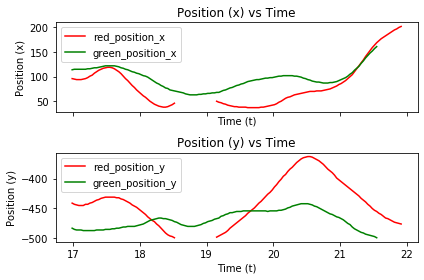

After cleaning:
cleaned_train_X has na: False
cleaned_train_y has na: False


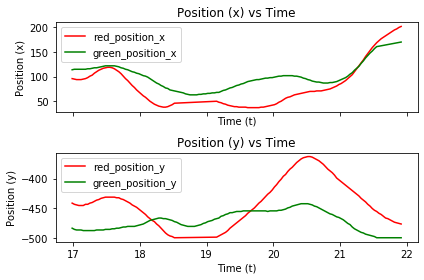

In [146]:
# Show that the interpolate function works.
print("Before cleaning:")
print(f"raw_train_X has na: {has_nulls(raw_train_X['green_position_x'])}")
print(f"raw_train_y has na: {has_nulls(raw_train_y)}")
cleaned_train_X = interpolate(raw_train_X, method=INTERPOLATION_METHOD)
cleaned_train_y = interpolate(raw_train_y, method=INTERPOLATION_METHOD)
cleaned_test_X = interpolate(raw_test_X, method=INTERPOLATION_METHOD)
cleaned_test_y = interpolate(raw_test_y, method=INTERPOLATION_METHOD)
plot_data = pd.concat((train_timestamps, raw_train_X, raw_train_y), axis=1)
plot(plot_data, start_t=17, total_t=5)

print("After cleaning:")
print(f"cleaned_train_X has na: {has_nulls(cleaned_train_X)}")
print(f"cleaned_train_y has na: {has_nulls(cleaned_train_y)}")
plot_data = pd.concat((train_timestamps, cleaned_train_X, cleaned_train_y), axis=1)
plot(plot_data, start_t=17, total_t=5)

# In order to use this function in a pipeline, we'll wrap it into FunctionTransformer.
interpolater = FunctionTransformer(interpolate, kw_args={"method": INTERPOLATION_METHOD})

### Exploratory Analysis

Choosing how to frame the problem is very important to get a optimal solution. So we'll want to explore the data to do so.

In [9]:
print("raw_train_X stats:")
raw_train_X.describe()

raw_train_X stats:


,green_position_x,green_position_y
count,813.000000,813.000000
mean,270.488315,-383.958180
std,151.050505,70.467096
min,63.000000,-499.000000
25%,127.000000,-454.000000
50%,234.000000,-377.000000
75%,386.000000,-333.000000
max,626.000000,-244.000000


In [10]:
print("raw_train_y stats:")
raw_train_y.describe()

raw_train_y stats:


,red_position_x,red_position_y
count,827.000000,827.000000
mean,279.394196,-372.623942
std,154.371111,66.828899
min,37.000000,-499.000000
25%,161.500000,-424.500000
50%,246.000000,-364.000000
75%,411.000000,-334.000000
max,664.000000,-197.000000


We can look at how the signals appear over time in both of their respective dimensions.

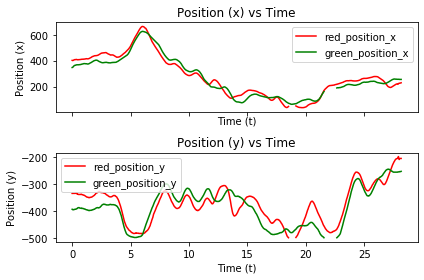

In [11]:
# This plot function allows us to specify a starting point and duration to zoom in on the data.
plot_data = pd.concat((train_timestamps, raw_train_X, raw_train_y), axis=1)
# Enter the start and stop times (in seconds) to see a plot of the training input. None means that the max possible time span is used.
plot(plot_data, start_t=0, total_t=None)

For development, we'll look at the test data to see if it will be a good fit for testing. But usually we want to avoid peeking into the test data to avoid becoming biased in our designs. 

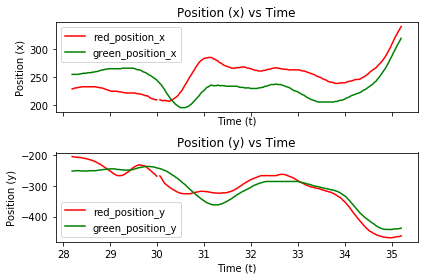

In [12]:
test_plot_data = pd.concat((test_timestamps, raw_test_X, raw_test_y), axis=1)
plot(test_plot_data, start_t=0, total_t=None)

It looks like this test data could provide a useful way to evaluate the accuracy of our model.

We can look at how the data is distributed.

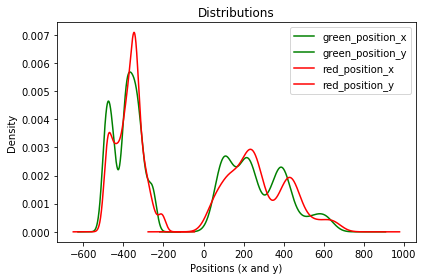

In [13]:
plot_data["green_position_x"].plot(kind="density", color="green")
plot_data["green_position_y"].plot(kind="density", color="green")
plot_data["red_position_x"].plot(kind="density", color="red")
plot_data["red_position_y"].plot(kind="density", color="red")
plt.title("Distributions")
plt.xlabel("Positions (x and y)")
plt.legend()
plt.tight_layout()
plt.show()

We can see that none of the signals are truly monomodal and that they are at least somewhat guassian. Many algorithms presume that the data is gaussian so this is good to check. At least the green and red portions seem to match fairly well which should help to forecast one with the other.

We can look at the frequency domain content of the position signals.

Level of signal: 266.87218934911243


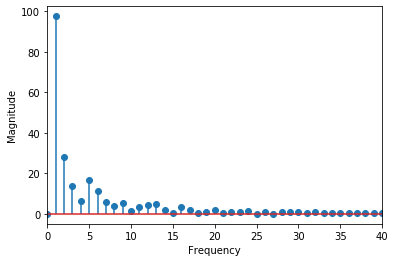

In [14]:
plot_spectrum(cleaned_train_X["green_position_x"], max_freq=40)

Level of signal: -388.3147928994083


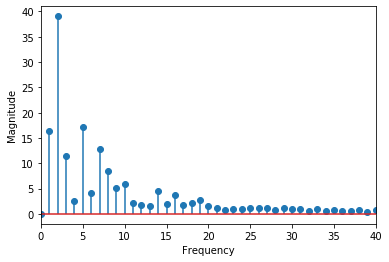

In [15]:
plot_spectrum(cleaned_train_X["green_position_y"], max_freq=40)

Level of signal: 274.4650887573965


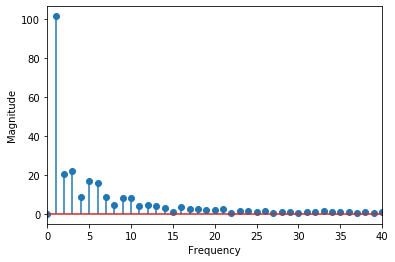

In [16]:
plot_spectrum(cleaned_train_y["red_position_x"], max_freq=40)

Level of signal: -375.30532544378696


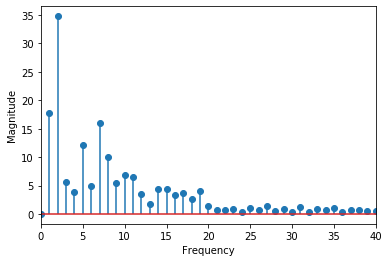

In [17]:
plot_spectrum(cleaned_train_y["red_position_y"], max_freq=40)

We see that the x dimension is dominated by a very low frequency component, which matchs its time domain graph. So it may be difficult to forecast it since it's not very periodic in nature. The y dimension is a bit more periodic as can be noted by the second spike in its frequency graphs.

Let's see what the correlations between the x and y dimensions of our lead and follow's signals are.

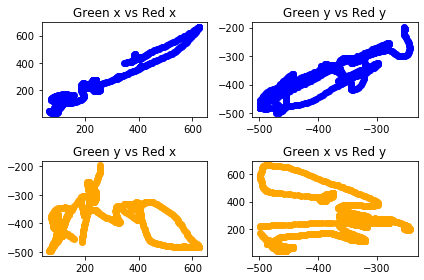

In [18]:
fig, ((xx, yy), (yx, xy)) = plt.subplots(nrows=2, ncols=2)
xx.scatter(plot_data["green_position_x"], plot_data["red_position_x"], label="green_position_x vs red_position_x", color="blue")
xx.set_title("Green x vs Red x")
yy.scatter(plot_data["green_position_y"], plot_data["red_position_y"], label="green_position_y vs red_position_y", color="blue")
yy.set_title("Green y vs Red y")
yx.scatter(plot_data["green_position_x"], plot_data["red_position_y"], label="green_position_x vs green_position_y", color="orange")
yx.set_title("Green y vs Red x")
xy.scatter(plot_data["green_position_y"], plot_data["red_position_x"], label="red_position_x vs red_position_y", color="orange")
xy.set_title("Green x vs Red y")
plt.tight_layout()
plt.show()

We can see that there *is* a linear correlation between the same dimensions but not in opposite dimensions. This correlation should make it easier to model $\vec{r}$ given $\vec{g}$.

We can also model the cross correlations as a function of lag amount.

In [19]:
gx_rx = signal_correlation(plot_data["green_position_x"], plot_data["red_position_x"])
gx_ry = signal_correlation(plot_data["green_position_x"], plot_data["red_position_y"])
gy_ry = signal_correlation(plot_data["green_position_y"], plot_data["red_position_y"])
gy_rx = signal_correlation(plot_data["green_position_y"], plot_data["red_position_x"])

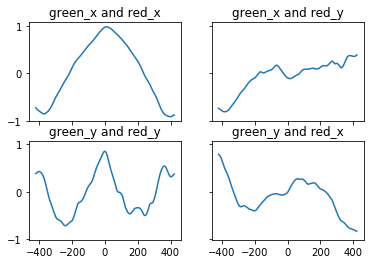

In [20]:
fig, ((xx, xy), (yy, yx)) = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True)
xx.plot(gx_rx[:,0], gx_rx[:,1])
xx.set_title("green_x and red_x")
xy.plot(gx_ry[:,0], gx_ry[:,1])
xy.set_title("green_x and red_y")
yy.plot(gy_ry[:,0], gy_ry[:,1])
yy.set_title("green_y and red_y")
yx.plot(gy_rx[:,0], gy_rx[:,1])
yx.set_title("green_y and red_x")
plt.show()

We can see that, once again, the signals are more correlated in their same dimensions. We can also see that the max correlation is actually very close to a lag of zero.

In [21]:
def get_best_lag(data):
    # Return a tuple (best abs correlation lag integer, best correlation)
    abs_data = np.apply_along_axis(abs, 0, data[:,1]) # We care about the absolute value.
    index = np.where(data==np.max(abs_data))[0][0] # The index is nested inside a matrix.
    best_corr = data[index,:]
    return int(best_corr[0]), best_corr[1]

best_xx = get_best_lag(gx_rx)
best_yy =get_best_lag(gy_ry)

print("x-->x y-->y")
print("xx: ", best_xx)
print("yy: ", best_yy)


x-->x y-->y
xx:  (9, 0.9775853813714515)
yy:  (-1, 0.8547090729879266)


We'll keep the offset at $k=1$, but `9` or `-1` show the max correlations for the x and y dimensions respectively.

We can also look at how each signal is correlated to itself as a function of lag.

Text(0.5, 1.0, 'Autocorrelations')

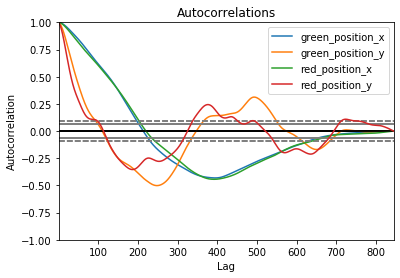

In [22]:
autocorrelation_plot(cleaned_train_X["green_position_x"], label="green_position_x")
autocorrelation_plot(cleaned_train_X["green_position_y"], label="green_position_y")
autocorrelation_plot(cleaned_train_y["red_position_x"], label="red_position_x")
autocorrelation_plot(cleaned_train_y["red_position_y"], label="red_position_y")
plt.title("Autocorrelations")

All the signals seem to approach a absolute value of `0` with increased leg. This shows that the signals are not stationary. Which is something we could see from the time domain graphs earlier. We'll try transforming the data to be zero centered and normalized, but this is a sign that the underlying process is more or less stochastic and will make it very difficult to forecast further into the future given the past.

### Encoding

Since our data is already numeric, there's no need to encode it.

### Baseline Model
We'll use the persistence or naive forecasting algorithm to set a baseline. This model simply returns $\vec{g}_{t+1}$ given $\vec{g}_t$, or whatever the last value was from its input. It's naive because it makes almost no assumtions and is very simple. If we can't reliably beat this baseline, then we're probably dealing with a random underlying process that fundementally isn't forecastable.

In [24]:
class Naive_Forecastor(BaseEstimator):
    def __init__(self):
        pass

    def predict(self, X):
        return X.shift(-1).iloc[:-1]

    def fit(self, X, y):
        # This essentially does nothing.
        pass
    
    def evaluate(self, X, y):
        y_hat = self.predict(X)
        return mean_absolute_error(y, y_hat)
            

naive_forecastor = Naive_Forecastor()

# Combining the steps into a pipeline is good practice.
basic_pipeline = Pipeline(steps=[
        ("interpolater", interpolater),
        ("estimator", naive_forecastor)
])
basic_pipeline.fit(raw_train_X, raw_train_y)
prediction = basic_pipeline.predict(raw_test_X)

### Baseline Evaluation
Our naive forecasting model is expected to not do very well (hence the name *naive*) because it simply uses the final timestep of the the input $\vec{g}_t$ for all of the timesteps of its $m \times 2$ output matrix $R$. But this gives us a baseline to compare our future models and quantify the improvement.

Here's a plot of the naively forecasted predictions compared to the ground truth test data.

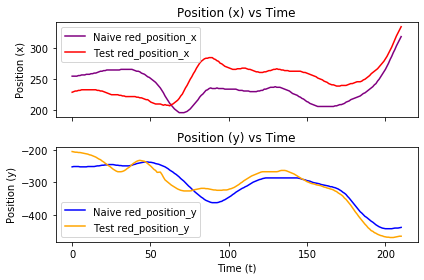

In [25]:
fig, (x_ax, y_ax) = plt.subplots(nrows=2, ncols=1, sharex=True)
# Dataframes are easier to work with.
prediction = pd.DataFrame(prediction)
# Interpolating the test data will remove any gaps.
test_plot_data = interpolate(raw_test_y, method=INTERPOLATION_METHOD)[:-1]
# We need the x components for the graphs.
pred_time = np.linspace(0, len(prediction), len(prediction))
x_ax.plot(pred_time, prediction["green_position_x"], color="purple", label="Naive red_position_x")
y_ax.plot(pred_time, prediction["green_position_y"], color="blue", label="Naive red_position_y")
x_ax.plot(pred_time, test_plot_data["red_position_x"], color="red", label="Test red_position_x")
y_ax.plot(pred_time, test_plot_data["red_position_y"], color="orange", label="Test red_position_y")
x_ax.set_title("Position (x) vs Time")
x_ax.set_ylabel("Position (x)")
x_ax.legend()
y_ax.set_title("Position (y) vs Time")
y_ax.set_xlabel("Time (t)")
y_ax.set_ylabel("Position (y)")
y_ax.legend()
plt.tight_layout()
plt.show()

If we subtracted the current model's output from the actual values at every point on the line and got the absolute value of the results, we'd have the residuals or the magnitudes of the errors of our model. It helps to visualize it by showing the area between the curves. This is the error from evaulation that we will aim to minimize by minimizing the hyperdimensional loss function of our network itself. Since our model never sees this data while training, having our model's curve closely fit our test curve is a good thing.

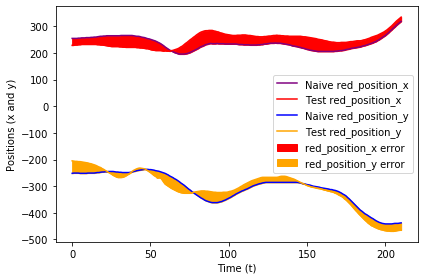

In [26]:
plt.plot(pred_time, prediction["green_position_x"], color="purple", label="Naive red_position_x")
plt.plot(pred_time, test_plot_data["red_position_x"], color="red", label="Test red_position_x")
plt.fill_between(pred_time, test_plot_data["red_position_x"], prediction["green_position_x"], color="red", label="red_position_x error")
plt.plot(pred_time, prediction["green_position_y"], color="blue", label="Naive red_position_y")
plt.plot(pred_time, test_plot_data["red_position_y"], color="orange", label="Test red_position_y")
plt.fill_between(pred_time, test_plot_data["red_position_y"], prediction["green_position_y"], color="orange", label="red_position_y error")

plt.xlabel("Time (t)")
plt.ylabel("Positions (x and y)")
plt.legend()
plt.tight_layout()
plt.show()

We can quantify our model's success with a single number. The metric will be the mean of the residuals or the absolute values of the errors for each datapoint. If the machine learning models struggle to beat this benchmark, then the underlying process generating the data is probably stochastic and unable to be accurately forecasted.

In [27]:
naive_evaluation = mean_absolute_error(test_plot_data, prediction)
print("Naive forecastor evaluation: ", naive_evaluation)

Naive forecastor evaluation:  26.746428571428574


### Feature Engineering

The movement of the lead probably has an effect on the movement of the follow. To capture this information, we'll make some new columns based on the fact that $\dot{x} = \frac{dx}{dt}$ and $\ddot{x} = \frac{d^{2}x}{dt^{2}}$ for both position vectors $\vec{g}$ and $\vec{r}$. $dt$ in this case is more accurately $\Delta{t}$ which is `1 / FPS`, or the inverse of the frame rate of the camera.

In [148]:
# Add the velocities and accelerations.
accel = cleaned_train_X.diff().diff() * FPS**2
cleaned_train_X[["green_velocity_x", "green_velocity_y"]] = cleaned_train_X.diff() * FPS
cleaned_train_X[["green_accel_x", "green_accel_y"]] = accel
accel = cleaned_train_y.diff().diff() * FPS**2
cleaned_train_y[["red_velocity_x", "red_velocity_y"]] = cleaned_train_y.diff() * FPS
cleaned_train_y[["red_accel_x", "red_accel_y"]] = accel
accel = cleaned_test_X.diff().diff() * FPS**2
cleaned_test_X[["green_velocity_x", "green_velocity_y"]] = cleaned_test_X.diff() * FPS
cleaned_test_X[["red_accel_x", "red_accel_y"]] = accel
accel = cleaned_test_y.diff().diff() * FPS**2
cleaned_test_y[["red_velocity_x", "red_velocity_y"]] = cleaned_test_y.diff() * FPS
cleaned_test_y[["red_accel_x", "red_accel_y"]] = accel

# Drop the first 2 rows since these have null values for our engineered features.
cleaned_train_X.dropna(axis=0, inplace=True)
cleaned_train_y.dropna(axis=0, inplace=True)
cleaned_test_X.dropna(axis=0, inplace=True)
cleaned_test_y.dropna(axis=0, inplace=True)

We can plot a second's worth of position, velocity and acceleration for the x dimension of the green vector. It looks to be correct.

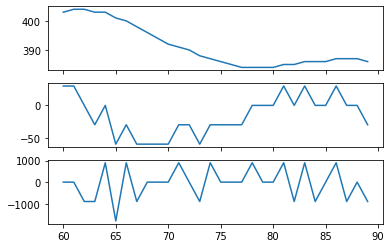

In [29]:
fig, axes = plt.subplots(nrows=3, sharex=True)
axes[0].plot(cleaned_train_X["green_position_x"].iloc[60:90])
axes[1].plot(cleaned_train_X["green_velocity_x"].iloc[60:90])
axes[2].plot(cleaned_train_X["green_accel_x"].iloc[60:90])

### Transformation

The ranges of our features are quite large. It'll be better to scale them down to a range that our models can handle. We'll also zero-center them so as to not skew the results. Note that we must fit our scaler object onto the `cleaned_train_X` and then use it for both feature 'x' and target 'y' data for both the train and test sets. This is because we assume that the training input is the only thing we'll be able to use in prediction and we don't want the mean and standard deviation of the test set to "leak" into the training data.

In [149]:
from sklearn.preprocessing import MinMaxScaler

minmax_scaler = MinMaxScaler()

minmax_scaler.fit(cleaned_train_X)

green_cols = ["green_position_x", "green_position_y", "green_velocity_x", "green_velocity_y", "green_accel_x", "green_accel_y"]
red_cols = ["red_position_x", "red_position_y", "red_velocity_x", "red_velocity_y", "red_accel_x", "red_accel_y"]
scaled_train_X = pd.DataFrame(minmax_scaler.transform(cleaned_train_X), columns=green_cols)
scaled_train_y = pd.DataFrame(minmax_scaler.transform(cleaned_train_y), columns=red_cols)
scaled_test_X = pd.DataFrame(minmax_scaler.transform(cleaned_test_X), columns=green_cols)
scaled_test_y = pd.DataFrame(minmax_scaler.transform(cleaned_test_y), columns=red_cols)
print("scaled_train_X: ")
print(scaled_train_X.describe())
print("scaled_train_y: ")
print(scaled_train_y.describe())

scaled_train_X: 
       green_position_x  green_position_y  green_velocity_x  green_velocity_y  \
count        843.000000        843.000000        843.000000        843.000000   
mean           0.361778          0.434108          0.492120          0.474496   
std            0.265383          0.284754          0.164476          0.171229   
min            0.000000          0.000000          0.000000          0.000000   
25%            0.122558          0.154902          0.428571          0.384615   
50%            0.296625          0.466667          0.500000          0.461538   
75%            0.571936          0.643137          0.571429          0.538462   
max            1.000000          1.000000          1.000000          1.000000   

       green_accel_x  green_accel_y  
count     843.000000     843.000000  
mean        0.512122       0.500593  
std         0.134215       0.201316  
min         0.000000       0.000000  
25%         0.349754       0.250000  
50%         0.512315     

In [150]:
# Let's update the datasets with these new features but we'll keep the old targets for position to not overcomplicate the problem.
features = FEATURES + ["green_velocity_x", "green_velocity_y", "green_accel_x", "green_accel_y"]
print("New features:", features)
print("Current targets:", TARGET)
scaled_train_y = scaled_train_y[TARGET]
scaled_test_y = scaled_test_y[TARGET]
scaled_train_y.head()

New features: ['green_position_x', 'green_position_y', 'green_velocity_x', 'green_velocity_y', 'green_accel_x', 'green_accel_y']
Current targets: ['red_position_x', 'red_position_y']


,red_position_x,red_position_y
0,0.600355,0.647059
1,0.603908,0.647059
2,0.605684,0.647059
3,0.609236,0.647059
4,0.611012,0.647059


### Sequencing

RRN-style neural networks need 3D tensor inputs of the shape (samples, timesteps, features). We can both model the problem as a supervised one and prepare the data to be in samples of sequences using the custom function below. This defines the functions and shows an example of them working. It uses a rolling window so that each sample overlaps with its neighbours. This is good for a regression problem, but classification problems usually do better with non-overlapping samples.

In [31]:
def sample_X(seq, sample_size=1, offset=0):
    # Return a Numpy array of shape (seq-sample_size, sample_size, feature_size)
    # given a sequence of vectors of size feature_size and whole number for sample_size.
    samples_amount = seq.shape[0] - sample_size
    return np.array([seq[i:i+sample_size] for i in range(offset, samples_amount)])

def sample_y(seq, sample_size=1, offset=1):
    # Return a Numpy array of shape (seq-sample_size+1, sample_size, feature_size)
    # given a sequence of vectors of size feature_size and whole number for sample_size.
    if sample_size < 2:
        return np.array([seq[i] for i in range(offset, len(seq))])
    return sample_X(seq, sample_size=sample_size, offset=offset)

def sample_X_y(X, y, history_size=1, forecast_size=1, offset=1):
    # Return the Numpy arrays for the X and y using their individual samples.
    X_offset = offset - 1
    X_samples = sample_X(X, sample_size=history_size, offset=X_offset)
    if forecast_size > 1:
        X_drop_amount = forecast_size
        X_samples = X_samples[:-X_drop_amount]
    y_offset = offset + history_size - 1
    y_samples = sample_y(y, sample_size=forecast_size, offset=y_offset)
    if offset > 1:
        X_samples = X_samples[:-offset+1].copy()
        y_samples = y_samples[offset-1:].copy()
    return X_samples, y_samples


# These parameters determine the shape of the sampled data:
history_size = 5
forecast_size = 1
offset = 1

# Testing the sampling functions.
X = np.arange(1, 41).reshape(-1, 2)
y = X.copy() * -1

print("history_size: ", history_size)
print("forecast_size: ", forecast_size)
print("offset: ", offset)

print("X shape: ", X.shape)
print("y shape: ", y.shape)
print("X")
print(X[:2])
print("y")
print(y[:2])

sampled_X, sampled_y = sample_X_y(X, y, history_size=history_size, forecast_size=forecast_size, offset=offset)
print("sampled_X shape: ", sampled_X.shape)
print("sampled_y shape: ", sampled_y.shape)
for x, y in zip(sampled_X[:2], sampled_y[:2]):
    print("sampled_X")
    print(x)
    print("sampled_y")
    print(y)

history_size:  5
forecast_size:  1
offset:  1
X shape:  (20, 2)
y shape:  (20, 2)
X
[[1 2]
 [3 4]]
y
[[-1 -2]
 [-3 -4]]
sampled_X shape:  (15, 5, 2)
sampled_y shape:  (15, 2)
sampled_X
[[ 1  2]
 [ 3  4]
 [ 5  6]
 [ 7  8]
 [ 9 10]]
sampled_y
[-11 -12]
sampled_X
[[ 3  4]
 [ 5  6]
 [ 7  8]
 [ 9 10]
 [11 12]]
sampled_y
[-13 -14]


We'll sample the data according to our predefined history and forecast window sizes $n$ and $m$, respectively. The forecast offset $k$ will be $1$ to to start predicting from the immediately next timestep. `history_size` is the amount of timesteps in $n$ and `forecast_timesteps` is the amount of timesteps out $m$. We'll set $m$ to $1$ to make our output more simple, considering we're already outputing a vector for position.

We could experiment to find the ideal size for $n$, but for now we'll set `history_size` close to the number of camera frames per second: `30`.

In [151]:
# The window sizes must be positive integers for the number of timesteps.
forecast_timesteps = 1
history_timesteps = 30

sampled_train_X, sampled_train_y = sample_X_y(scaled_train_X.to_numpy(), scaled_train_y.to_numpy(), history_size=history_timesteps, forecast_size=forecast_timesteps, offset=1)
sampled_test_X, sampled_test_y = sample_X_y(scaled_test_X.to_numpy(), scaled_test_y.to_numpy(), history_size=history_timesteps, forecast_size=forecast_timesteps, offset=1)

# This code can be uncomented to try only using and predicting the x dimension. But by default it should be uncommented to use both dimensions.
# n_train_samples = sampled_train_X.shape[0]
# sampled_train_X = sampled_train_X[:,:,0].reshape(n_train_samples, -1, 1)
# sampled_train_y = sampled_train_y[:,0].reshape(n_train_samples, 1)
# n_test_samples = sampled_test_X.shape[0]
# sampled_test_X = sampled_test_X[:,:,0].reshape(n_test_samples, -1, 1)
# sampled_test_y = sampled_test_y[:,0].reshape(n_test_samples, 1)

# We can check the shapes of our sampled datasets.
print("history_timesteps: ", history_timesteps)
print("forecast_timesteps: ", forecast_timesteps)
print("Shapes are (samples, timesteps, features)")
print("sampled_train_X shape: ", sampled_train_X.shape)
print("sampled_train_y shape: ", sampled_train_y.shape)

history_timesteps:  30
forecast_timesteps:  1
Shapes are (samples, timesteps, features)
sampled_train_X shape:  (813, 30, 6)
sampled_train_y shape:  (813, 2)


There is a trade off between the number of timesteps and the number of samples. Short timeframes give many training samples, but they don't provide much context for the memory units in a LSTM. But using long timeframes means there are less samples to use.

# Model Selection and Optimization

### Model Selection and Construction

In [34]:
# These functions simply return lstm models given their parameters.

def build_stateful_model(history_timesteps, batch_size=1, input_size=1, output_size=1, hidden_size=1, hidden_activation="tanh", output_activation="linear"):
    # Return a stateful LSTM given the various arguments. It's stateful because it the memory units are only reset between epochs.
    model = Sequential()
    model.add(LSTM(units=hidden_size, batch_input_shape=(batch_size, history_timesteps, input_size), activation=hidden_activation, stateful=True))
    model.add(Dense(units=output_size, activation=output_activation))
    model.compile(loss="mse", optimizer="adam", metrics=["mae"])
    return model

def build_stateless_model(history_timesteps, batch_size=1, input_size=1, output_size=1, hidden_size=1, hidden_activation="tanh", output_activation="linear"):
    # Return a stateless LSTM given the various arguments. It's stateless because it the memory units are reset between batches by default.
    model = Sequential()
    model.add(LSTM(units=hidden_size, input_shape=(history_timesteps, input_size), stateful=False))
    model.add(Dense(units=output_size, activation=output_activation))
    model.compile(loss="mse", optimizer="adam", metrics=["mae"])
    return model

def build_mlp_model(hidden_sizes=(1, 1), history_timesteps=1, input_size=1, hidden_activation="relu", output_activation="linear", output_size=1):
    # Return a multilayer perceptron given the various arguments.
    model = Sequential()
    model.add(Dense(units=hidden_sizes[0], input_shape=(history_timesteps*input_size,), activation=hidden_activation))
    model.add(Dense(units=hidden_sizes[1], activation=HIDDEN_ACTIVATION))
    model.add(Dense(units=output_size, activation=output_activation))
    model.compile(loss="mse", optimizer="adam", metrics=["mae"])
    return model

### Training and Hyperparameter Optimization

In [35]:
# These functions are used to fit the lstm, since doing so statefully is different than fitting a stateless model.

def fit_stateful_lstm(lstm, X, y, epochs=1, batch_size=None, callbacks=None, validation_split=0):
    # Fit a stateful LSTM and reset the memory for each epoch.
    if callbacks is None:
        callbacks=[]
    for epoch in range(1, epochs+1):
        print(f"Epoch number: {epoch}")
        lstm.reset_states()
        yield lstm.fit(X, y, epochs=1, batch_size=batch_size, shuffle=False, callbacks=callbacks, validation_split=validation_split)

def fit_stateless_lstm(lstm, X, y, epochs=1, batch_size=1, callbacks=None, validation_split=0):
    # Fit a stateless LSTM the default way.
    if callbacks is None:
        callbacks=[]
    return lstm.fit(X, y, epochs=epochs, batch_size=batch_size, shuffle=False, callbacks=callbacks, validation_split=validation_split)

We can set up some callbacks to give us some finer control over the fitting process. `EarlyStopping` allows us to stop the fit when the loss or validation starts to go up for `patience` number of epochs. `ModelCheckpoint` allows us to save the best weights to a file and load them in later so that we don't have to worry about bouncing out of a minimum in our loss space.

Let's test that our LSTM architecture works properly by contriving a simple problem: predicting a compound sine wave. We'll make up some test data and then sequence it (but slightly differently than using our sequencing function earlier because this data is univariate.)

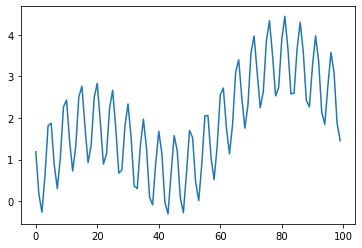

In [36]:
# We can use a sine wave to test that our model's architecture is sound.
sf = 100 # Sample freq
end_time = 10
start_time = 0
level = 0.5
trend = 0.25
season_freq = 1
noise_freq = 50
season_phase = 0
noise_phase = np.pi/4
t = np.linspace(start_time, end_time, sf)
ssignal = np.sin(t*0+level)
ssignal += t*np.sin(trend)
ssignal += np.sin(t*season_freq+season_phase)
ssignal += np.sin(t*noise_freq+noise_phase)
plt.plot(ssignal)

In [37]:
# Sequence the sine wave.
signal_samples = len(ssignal)
history_timesteps = 5
n_samples = signal_samples - history_timesteps + 1
signal_x = []
signal_y = []

for i in range(0, n_samples):
    try:
        signal_x.append(ssignal[i:i+history_timesteps])
        signal_y.append(ssignal[i+history_timesteps])
    except IndexError:
        pass
signal_x.pop() # We can't use the last sample for X because we've run out of future values for y so we should drop it.
signal_x = np.array(signal_x).reshape(n_samples-1, history_timesteps, 1)
signal_y = np.array(signal_y).reshape(n_samples-1, 1)
print(signal_x.shape)
print(signal_y.shape)
print("signal_samples", signal_samples)
print("n_samples max", n_samples)
print("history_timesteps", history_timesteps)
train_signal_x, test_signal_x = signal_x[:-10], signal_x[-10:]
train_signal_y, test_signal_y = signal_y[:-10], signal_y[-10:]

(95, 5, 1)
(95, 1)
signal_samples 100
n_samples max 96
history_timesteps 5


In [51]:
lstm = build_stateless_model(history_timesteps=5, batch_size=1, input_size=1, output_size=1, hidden_size=2, hidden_activation="tanh", output_activation="linear")
lstm.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 2)                 32        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 3         
Total params: 35
Trainable params: 35
Non-trainable params: 0
_________________________________________________________________


In [56]:
# Set early stopping to prevent overfitting.
loss_es = EarlyStopping(monitor="mae", mode="min", patience=20)
val_es = EarlyStopping(monitor="val_mae", mode="min", patience=10)
# Set a checkpoint to get the best weights.
weights_filepath = "sine_weights.hdf5"
sine_checkpoint = ModelCheckpoint(weights_filepath, monitor="val_mae", verbose=1, save_best_only=True, mode="min")

In [57]:
history = lstm.fit(train_signal_x, train_signal_y, epochs=1000, batch_size=1, shuffle=False, callbacks=[loss_es, val_es, sine_checkpoint], validation_split=0.1)

Train on 76 samples, validate on 9 samples
Epoch 1/1000
76/76 [==============================] - 0s 3ms/step - loss: 0.1583 - mae: 0.3427 - val_loss: 0.2907 - val_mae: 0.4435

Epoch 00001: val_mae improved from inf to 0.44349, saving model to sine_weights.hdf5
Epoch 2/1000
76/76 [==============================] - 0s 3ms/step - loss: 0.1577 - mae: 0.3420 - val_loss: 0.2901 - val_mae: 0.4431

Epoch 00002: val_mae improved from 0.44349 to 0.44309, saving model to sine_weights.hdf5
Epoch 3/1000
76/76 [==============================] - 0s 3ms/step - loss: 0.1572 - mae: 0.3414 - val_loss: 0.2895 - val_mae: 0.4427

Epoch 00003: val_mae improved from 0.44309 to 0.44270, saving model to sine_weights.hdf5
Epoch 4/1000
76/76 [==============================] - 0s 3ms/step - loss: 0.1566 - mae: 0.3408 - val_loss: 0.2890 - val_mae: 0.4423

Epoch 00004: val_mae improved from 0.44270 to 0.44230, saving model to sine_weights.hdf5
Epoch 5/1000
76/76 [==============================] - 0s 3ms/step - loss:

Epoch 38/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.1395 - mae: 0.3208 - val_loss: 0.2743 - val_mae: 0.4307

Epoch 00038: val_mae improved from 0.43098 to 0.43067, saving model to sine_weights.hdf5
Epoch 39/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.1391 - mae: 0.3203 - val_loss: 0.2739 - val_mae: 0.4304

Epoch 00039: val_mae improved from 0.43067 to 0.43037, saving model to sine_weights.hdf5
Epoch 40/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.1387 - mae: 0.3198 - val_loss: 0.2736 - val_mae: 0.4301

Epoch 00040: val_mae improved from 0.43037 to 0.43006, saving model to sine_weights.hdf5
Epoch 41/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.1382 - mae: 0.3192 - val_loss: 0.2733 - val_mae: 0.4298

Epoch 00041: val_mae improved from 0.43006 to 0.42976, saving model to sine_weights.hdf5
Epoch 42/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.1378 - mae: 0.3187 - val_loss: 

Epoch 75/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.1255 - mae: 0.3030 - val_loss: 0.2639 - val_mae: 0.4204

Epoch 00075: val_mae improved from 0.42062 to 0.42036, saving model to sine_weights.hdf5
Epoch 76/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.1252 - mae: 0.3025 - val_loss: 0.2637 - val_mae: 0.4201

Epoch 00076: val_mae improved from 0.42036 to 0.42010, saving model to sine_weights.hdf5
Epoch 77/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.1249 - mae: 0.3021 - val_loss: 0.2635 - val_mae: 0.4198

Epoch 00077: val_mae improved from 0.42010 to 0.41984, saving model to sine_weights.hdf5
Epoch 78/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.1245 - mae: 0.3017 - val_loss: 0.2632 - val_mae: 0.4196

Epoch 00078: val_mae improved from 0.41984 to 0.41959, saving model to sine_weights.hdf5
Epoch 79/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.1242 - mae: 0.3012 - val_loss: 

Epoch 112/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.1149 - mae: 0.2881 - val_loss: 0.2560 - val_mae: 0.4155

Epoch 00112: val_mae improved from 0.41566 to 0.41554, saving model to sine_weights.hdf5
Epoch 113/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.1147 - mae: 0.2877 - val_loss: 0.2558 - val_mae: 0.4154

Epoch 00113: val_mae improved from 0.41554 to 0.41541, saving model to sine_weights.hdf5
Epoch 114/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.1145 - mae: 0.2873 - val_loss: 0.2556 - val_mae: 0.4153

Epoch 00114: val_mae improved from 0.41541 to 0.41529, saving model to sine_weights.hdf5
Epoch 115/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.1142 - mae: 0.2869 - val_loss: 0.2554 - val_mae: 0.4152

Epoch 00115: val_mae improved from 0.41529 to 0.41517, saving model to sine_weights.hdf5
Epoch 116/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.1140 - mae: 0.2866 - val_l


Epoch 00148: val_mae improved from 0.41090 to 0.41076, saving model to sine_weights.hdf5
Epoch 149/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.1067 - mae: 0.2753 - val_loss: 0.2490 - val_mae: 0.4106

Epoch 00149: val_mae improved from 0.41076 to 0.41062, saving model to sine_weights.hdf5
Epoch 150/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.1065 - mae: 0.2750 - val_loss: 0.2489 - val_mae: 0.4105

Epoch 00150: val_mae improved from 0.41062 to 0.41048, saving model to sine_weights.hdf5
Epoch 151/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.1063 - mae: 0.2747 - val_loss: 0.2487 - val_mae: 0.4103

Epoch 00151: val_mae improved from 0.41048 to 0.41033, saving model to sine_weights.hdf5
Epoch 152/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.1061 - mae: 0.2744 - val_loss: 0.2485 - val_mae: 0.4102

Epoch 00152: val_mae improved from 0.41033 to 0.41019, saving model to sine_weights.hdf5
Epoch 153/1000

Epoch 222/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0944 - mae: 0.2570 - val_loss: 0.2370 - val_mae: 0.3999

Epoch 00222: val_mae improved from 0.40004 to 0.39990, saving model to sine_weights.hdf5
Epoch 223/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0943 - mae: 0.2568 - val_loss: 0.2368 - val_mae: 0.3998

Epoch 00223: val_mae improved from 0.39990 to 0.39975, saving model to sine_weights.hdf5
Epoch 224/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0941 - mae: 0.2566 - val_loss: 0.2367 - val_mae: 0.3996

Epoch 00224: val_mae improved from 0.39975 to 0.39961, saving model to sine_weights.hdf5
Epoch 225/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0940 - mae: 0.2564 - val_loss: 0.2365 - val_mae: 0.3995

Epoch 00225: val_mae improved from 0.39961 to 0.39946, saving model to sine_weights.hdf5
Epoch 226/1000
76/76 [==============================] - 0s 3ms/step - loss: 0.0938 - mae: 0.2562 - val_l


Epoch 00258: val_mae improved from 0.39491 to 0.39477, saving model to sine_weights.hdf5
Epoch 259/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0894 - mae: 0.2500 - val_loss: 0.2317 - val_mae: 0.3946

Epoch 00259: val_mae improved from 0.39477 to 0.39463, saving model to sine_weights.hdf5
Epoch 260/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0893 - mae: 0.2499 - val_loss: 0.2315 - val_mae: 0.3945

Epoch 00260: val_mae improved from 0.39463 to 0.39449, saving model to sine_weights.hdf5
Epoch 261/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0892 - mae: 0.2497 - val_loss: 0.2314 - val_mae: 0.3944

Epoch 00261: val_mae improved from 0.39449 to 0.39436, saving model to sine_weights.hdf5
Epoch 262/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0890 - mae: 0.2495 - val_loss: 0.2313 - val_mae: 0.3942

Epoch 00262: val_mae improved from 0.39436 to 0.39422, saving model to sine_weights.hdf5
Epoch 263/1000

Epoch 332/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0810 - mae: 0.2381 - val_loss: 0.2225 - val_mae: 0.3850

Epoch 00332: val_mae improved from 0.38513 to 0.38500, saving model to sine_weights.hdf5
Epoch 333/1000
76/76 [==============================] - 0s 3ms/step - loss: 0.0809 - mae: 0.2380 - val_loss: 0.2224 - val_mae: 0.3849

Epoch 00333: val_mae improved from 0.38500 to 0.38488, saving model to sine_weights.hdf5
Epoch 334/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0808 - mae: 0.2378 - val_loss: 0.2223 - val_mae: 0.3847

Epoch 00334: val_mae improved from 0.38488 to 0.38475, saving model to sine_weights.hdf5
Epoch 335/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0807 - mae: 0.2377 - val_loss: 0.2222 - val_mae: 0.3846

Epoch 00335: val_mae improved from 0.38475 to 0.38462, saving model to sine_weights.hdf5
Epoch 336/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0806 - mae: 0.2375 - val_l


Epoch 00368: val_mae improved from 0.38061 to 0.38048, saving model to sine_weights.hdf5
Epoch 369/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0774 - mae: 0.2325 - val_loss: 0.2183 - val_mae: 0.3804

Epoch 00369: val_mae improved from 0.38048 to 0.38036, saving model to sine_weights.hdf5
Epoch 370/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0773 - mae: 0.2324 - val_loss: 0.2182 - val_mae: 0.3802

Epoch 00370: val_mae improved from 0.38036 to 0.38024, saving model to sine_weights.hdf5
Epoch 371/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0772 - mae: 0.2323 - val_loss: 0.2181 - val_mae: 0.3801

Epoch 00371: val_mae improved from 0.38024 to 0.38011, saving model to sine_weights.hdf5
Epoch 372/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0771 - mae: 0.2321 - val_loss: 0.2180 - val_mae: 0.3800

Epoch 00372: val_mae improved from 0.38011 to 0.37999, saving model to sine_weights.hdf5
Epoch 373/1000

Epoch 442/1000
76/76 [==============================] - 0s 3ms/step - loss: 0.0711 - mae: 0.2227 - val_loss: 0.2107 - val_mae: 0.3713

Epoch 00442: val_mae improved from 0.37139 to 0.37126, saving model to sine_weights.hdf5
Epoch 443/1000
76/76 [==============================] - 0s 3ms/step - loss: 0.0710 - mae: 0.2226 - val_loss: 0.2106 - val_mae: 0.3711

Epoch 00443: val_mae improved from 0.37126 to 0.37113, saving model to sine_weights.hdf5
Epoch 444/1000
76/76 [==============================] - 0s 3ms/step - loss: 0.0709 - mae: 0.2224 - val_loss: 0.2105 - val_mae: 0.3710

Epoch 00444: val_mae improved from 0.37113 to 0.37101, saving model to sine_weights.hdf5
Epoch 445/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0708 - mae: 0.2223 - val_loss: 0.2104 - val_mae: 0.3709

Epoch 00445: val_mae improved from 0.37101 to 0.37088, saving model to sine_weights.hdf5
Epoch 446/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0708 - mae: 0.2222 - val_l


Epoch 00478: val_mae improved from 0.36686 to 0.36673, saving model to sine_weights.hdf5
Epoch 479/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0683 - mae: 0.2184 - val_loss: 0.2070 - val_mae: 0.3666

Epoch 00479: val_mae improved from 0.36673 to 0.36660, saving model to sine_weights.hdf5
Epoch 480/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0682 - mae: 0.2182 - val_loss: 0.2069 - val_mae: 0.3665

Epoch 00480: val_mae improved from 0.36660 to 0.36648, saving model to sine_weights.hdf5
Epoch 481/1000
76/76 [==============================] - 0s 3ms/step - loss: 0.0681 - mae: 0.2181 - val_loss: 0.2068 - val_mae: 0.3664

Epoch 00481: val_mae improved from 0.36648 to 0.36635, saving model to sine_weights.hdf5
Epoch 482/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0681 - mae: 0.2180 - val_loss: 0.2067 - val_mae: 0.3662

Epoch 00482: val_mae improved from 0.36635 to 0.36623, saving model to sine_weights.hdf5
Epoch 483/1000

Epoch 552/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0634 - mae: 0.2103 - val_loss: 0.2002 - val_mae: 0.3614

Epoch 00552: val_mae improved from 0.36143 to 0.36138, saving model to sine_weights.hdf5
Epoch 553/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0634 - mae: 0.2102 - val_loss: 0.2001 - val_mae: 0.3613

Epoch 00553: val_mae improved from 0.36138 to 0.36132, saving model to sine_weights.hdf5
Epoch 554/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0633 - mae: 0.2101 - val_loss: 0.2001 - val_mae: 0.3613

Epoch 00554: val_mae improved from 0.36132 to 0.36126, saving model to sine_weights.hdf5
Epoch 555/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0632 - mae: 0.2101 - val_loss: 0.2000 - val_mae: 0.3612

Epoch 00555: val_mae improved from 0.36126 to 0.36121, saving model to sine_weights.hdf5
Epoch 556/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0632 - mae: 0.2100 - val_l


Epoch 00588: val_mae improved from 0.35931 to 0.35925, saving model to sine_weights.hdf5
Epoch 589/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0613 - mae: 0.2068 - val_loss: 0.1970 - val_mae: 0.3592

Epoch 00589: val_mae improved from 0.35925 to 0.35919, saving model to sine_weights.hdf5
Epoch 590/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0612 - mae: 0.2067 - val_loss: 0.1969 - val_mae: 0.3591

Epoch 00590: val_mae improved from 0.35919 to 0.35913, saving model to sine_weights.hdf5
Epoch 591/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0612 - mae: 0.2066 - val_loss: 0.1969 - val_mae: 0.3591

Epoch 00591: val_mae improved from 0.35913 to 0.35906, saving model to sine_weights.hdf5
Epoch 592/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0611 - mae: 0.2065 - val_loss: 0.1968 - val_mae: 0.3590

Epoch 00592: val_mae improved from 0.35906 to 0.35900, saving model to sine_weights.hdf5
Epoch 593/1000

76/76 [==============================] - ETA: 0s - loss: 0.0573 - mae: 0.203 - 0s 2ms/step - loss: 0.0574 - mae: 0.2007 - val_loss: 0.1910 - val_mae: 0.3542

Epoch 00662: val_mae improved from 0.35429 to 0.35421, saving model to sine_weights.hdf5
Epoch 663/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0574 - mae: 0.2006 - val_loss: 0.1910 - val_mae: 0.3541

Epoch 00663: val_mae improved from 0.35421 to 0.35414, saving model to sine_weights.hdf5
Epoch 664/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0573 - mae: 0.2005 - val_loss: 0.1909 - val_mae: 0.3541

Epoch 00664: val_mae improved from 0.35414 to 0.35407, saving model to sine_weights.hdf5
Epoch 665/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0573 - mae: 0.2004 - val_loss: 0.1908 - val_mae: 0.3540

Epoch 00665: val_mae improved from 0.35407 to 0.35399, saving model to sine_weights.hdf5
Epoch 666/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.057


Epoch 00698: val_mae improved from 0.35153 to 0.35145, saving model to sine_weights.hdf5
Epoch 699/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0557 - mae: 0.1981 - val_loss: 0.1881 - val_mae: 0.3514

Epoch 00699: val_mae improved from 0.35145 to 0.35137, saving model to sine_weights.hdf5
Epoch 700/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0556 - mae: 0.1981 - val_loss: 0.1880 - val_mae: 0.3513

Epoch 00700: val_mae improved from 0.35137 to 0.35129, saving model to sine_weights.hdf5
Epoch 701/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0556 - mae: 0.1980 - val_loss: 0.1879 - val_mae: 0.3512

Epoch 00701: val_mae improved from 0.35129 to 0.35121, saving model to sine_weights.hdf5
Epoch 702/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0556 - mae: 0.1979 - val_loss: 0.1878 - val_mae: 0.3511

Epoch 00702: val_mae improved from 0.35121 to 0.35113, saving model to sine_weights.hdf5
Epoch 703/1000

76/76 [==============================] - 0s 3ms/step - loss: 0.0525 - mae: 0.1934 - val_loss: 0.1820 - val_mae: 0.3451

Epoch 00772: val_mae improved from 0.34516 to 0.34507, saving model to sine_weights.hdf5
Epoch 773/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0525 - mae: 0.1933 - val_loss: 0.1819 - val_mae: 0.3450

Epoch 00773: val_mae improved from 0.34507 to 0.34497, saving model to sine_weights.hdf5
Epoch 774/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0524 - mae: 0.1933 - val_loss: 0.1819 - val_mae: 0.3449

Epoch 00774: val_mae improved from 0.34497 to 0.34488, saving model to sine_weights.hdf5
Epoch 775/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0524 - mae: 0.1932 - val_loss: 0.1818 - val_mae: 0.3448

Epoch 00775: val_mae improved from 0.34488 to 0.34479, saving model to sine_weights.hdf5
Epoch 776/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0524 - mae: 0.1931 - val_loss: 0.1817 - v

Epoch 809/1000
76/76 [==============================] - 0s 3ms/step - loss: 0.0511 - mae: 0.1910 - val_loss: 0.1788 - val_mae: 0.3415

Epoch 00809: val_mae improved from 0.34162 to 0.34152, saving model to sine_weights.hdf5
Epoch 810/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0510 - mae: 0.1910 - val_loss: 0.1787 - val_mae: 0.3414

Epoch 00810: val_mae improved from 0.34152 to 0.34143, saving model to sine_weights.hdf5
Epoch 811/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0510 - mae: 0.1909 - val_loss: 0.1786 - val_mae: 0.3413

Epoch 00811: val_mae improved from 0.34143 to 0.34133, saving model to sine_weights.hdf5
Epoch 812/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0509 - mae: 0.1909 - val_loss: 0.1785 - val_mae: 0.3412

Epoch 00812: val_mae improved from 0.34133 to 0.34123, saving model to sine_weights.hdf5
Epoch 813/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0509 - mae: 0.1908 - val_l


Epoch 00845: val_mae improved from 0.33799 to 0.33789, saving model to sine_weights.hdf5
Epoch 846/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0497 - mae: 0.1886 - val_loss: 0.1754 - val_mae: 0.3378

Epoch 00846: val_mae improved from 0.33789 to 0.33779, saving model to sine_weights.hdf5
Epoch 847/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0497 - mae: 0.1886 - val_loss: 0.1754 - val_mae: 0.3377

Epoch 00847: val_mae improved from 0.33779 to 0.33768, saving model to sine_weights.hdf5
Epoch 848/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0496 - mae: 0.1885 - val_loss: 0.1753 - val_mae: 0.3376

Epoch 00848: val_mae improved from 0.33768 to 0.33758, saving model to sine_weights.hdf5
Epoch 849/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0496 - mae: 0.1885 - val_loss: 0.1752 - val_mae: 0.3375

Epoch 00849: val_mae improved from 0.33758 to 0.33748, saving model to sine_weights.hdf5
Epoch 850/1000

76/76 [==============================] - 0s 3ms/step - loss: 0.0472 - mae: 0.1839 - val_loss: 0.1687 - val_mae: 0.3301

Epoch 00919: val_mae improved from 0.33018 to 0.33008, saving model to sine_weights.hdf5
Epoch 920/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0472 - mae: 0.1838 - val_loss: 0.1686 - val_mae: 0.3300

Epoch 00920: val_mae improved from 0.33008 to 0.32997, saving model to sine_weights.hdf5
Epoch 921/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0471 - mae: 0.1838 - val_loss: 0.1686 - val_mae: 0.3299

Epoch 00921: val_mae improved from 0.32997 to 0.32986, saving model to sine_weights.hdf5
Epoch 922/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0471 - mae: 0.1837 - val_loss: 0.1685 - val_mae: 0.3298

Epoch 00922: val_mae improved from 0.32986 to 0.32976, saving model to sine_weights.hdf5
Epoch 923/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0471 - mae: 0.1836 - val_loss: 0.1684 - v

Epoch 956/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0460 - mae: 0.1815 - val_loss: 0.1654 - val_mae: 0.3261

Epoch 00956: val_mae improved from 0.32624 to 0.32613, saving model to sine_weights.hdf5
Epoch 957/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0460 - mae: 0.1815 - val_loss: 0.1653 - val_mae: 0.3260

Epoch 00957: val_mae improved from 0.32613 to 0.32602, saving model to sine_weights.hdf5
Epoch 958/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0460 - mae: 0.1814 - val_loss: 0.1652 - val_mae: 0.3259

Epoch 00958: val_mae improved from 0.32602 to 0.32592, saving model to sine_weights.hdf5
Epoch 959/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0459 - mae: 0.1814 - val_loss: 0.1651 - val_mae: 0.3258

Epoch 00959: val_mae improved from 0.32592 to 0.32581, saving model to sine_weights.hdf5
Epoch 960/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0459 - mae: 0.1813 - val_l


Epoch 00992: val_mae improved from 0.32244 to 0.32233, saving model to sine_weights.hdf5
Epoch 993/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0449 - mae: 0.1793 - val_loss: 0.1621 - val_mae: 0.3222

Epoch 00993: val_mae improved from 0.32233 to 0.32223, saving model to sine_weights.hdf5
Epoch 994/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0449 - mae: 0.1793 - val_loss: 0.1620 - val_mae: 0.3221

Epoch 00994: val_mae improved from 0.32223 to 0.32212, saving model to sine_weights.hdf5
Epoch 995/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0449 - mae: 0.1792 - val_loss: 0.1619 - val_mae: 0.3220

Epoch 00995: val_mae improved from 0.32212 to 0.32202, saving model to sine_weights.hdf5
Epoch 996/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0448 - mae: 0.1792 - val_loss: 0.1619 - val_mae: 0.3219

Epoch 00996: val_mae improved from 0.32202 to 0.32191, saving model to sine_weights.hdf5
Epoch 997/1000

Text(0.5, 1.0, 'Error over Epochs')

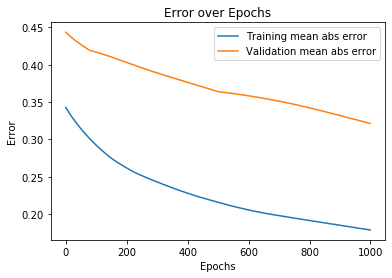

In [58]:
# Plot the training history.
plt.plot(history.history["mae"], label="Training mean abs error")
plt.plot(history.history["val_mae"], label="Validation mean abs error")
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.legend()
plt.title("Error over Epochs")

In [61]:
# Load the best weights.
lstm.load_weights("sine_weights.hdf5")

Text(0.5, 1.0, 'Training Prediction')

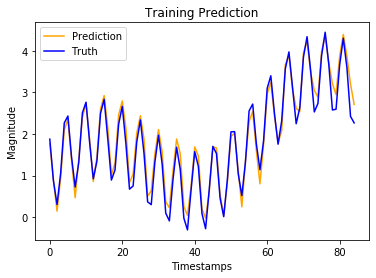

In [62]:
y_hat = lstm.predict(train_signal_x, batch_size=1)
plt.plot(y_hat, color="orange", label="Prediction")
plt.plot(train_signal_y, color="blue", label="Truth")
plt.xlabel("Timestamps")
plt.ylabel("Magnitude")
plt.legend()
plt.title("Training Prediction")

Text(0.5, 1.0, 'Testing Prediction')

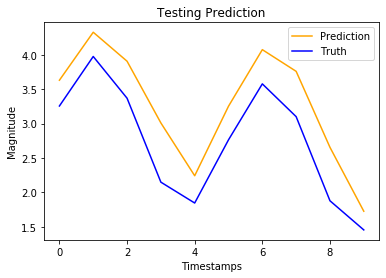

In [63]:
y_hat = lstm.predict(test_signal_x, batch_size=1)
plt.plot(y_hat, color="orange", label="Prediction")
plt.plot(test_signal_y, color="blue", label="Truth")
plt.xlabel("Timestamps")
plt.ylabel("Magnitude")
plt.legend()
plt.title("Testing Prediction")

We can see that the LSTM set up works! It could get arbitrarily close to approximating our dummy sine function. Now let's try it out with our real data.

In [158]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from keras.wrappers.scikit_learn import KerasRegressor

def build_custom_model(hidden_units, has_second_layer):
    model = Sequential()
    if has_second_layer:
        model.add(LSTM(units=hidden_units, input_shape=(30, 6), stateful=False, return_sequences=True))
        model.add(LSTM(units=2))
    else:
        model.add(LSTM(units=hidden_units, input_shape=(30, 6), stateful=False))
    model.add(Dense(units=2, activation="linear"))
    model.compile(loss="mse", optimizer="adam", metrics=["mae"])
    return model

model = KerasRegressor(build_custom_model, 
                       epochs=2, 
                       batch_size=1, 
                       shuffle=False,
)

hyperparameters = {
    "hidden_units": (2, 8, 32, 128),
    "has_second_layer": (False, True),
}

mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

grid = RandomizedSearchCV(model, verbose=2,
                               random_state=0, # For reproducibility.
                               n_iter=5, # Try this many combinations.
                               param_distributions=hyperparameters,
                               scoring=mse_scorer,
                               cv=2, # The number of splits to make.
                               n_jobs=-1 # n_jobs=-1 means to use max CPUS.
)
# grid = GridSearchCV(model, verbose=2,
#                                param_grid=hyperparameters,
#                                scoring=mse_scorer,
#                                cv=2, # The number of splits to make.
#                                n_jobs=-1 # n_jobs=-1 means to use max CPUS.
# )

In [159]:
grid_result = grid.fit(sampled_train_X, sampled_train_y)

Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.3min finished


Epoch 1/2
813/813 [==============================] - 8s 10ms/step - loss: 0.0446 - mae: 0.1132
Epoch 2/2
813/813 [==============================] - 8s 9ms/step - loss: 0.0105 - mae: 0.0736


We can look at the results of randomly trying different hyperparameters.

In [160]:
pd.DataFrame(grid_result.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_hidden_units,param_has_second_layer,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
0,34.371477,0.353539,2.727300,0.036694,32,True,"{'hidden_units': 32, 'has_second_layer': True}",-0.251173,-0.067904,-0.159539,0.091635,2
1,23.415612,0.092463,1.610250,0.026471,32,False,"{'hidden_units': 32, 'has_second_layer': False}",-0.368147,-0.053064,-0.210606,0.157541,5
2,16.615233,1.308176,1.354248,0.056777,8,False,"{'hidden_units': 8, 'has_second_layer': False}",-0.185151,-0.060902,-0.123026,0.062125,1
3,35.708109,0.173434,2.390187,0.016502,128,True,"{'hidden_units': 128, 'has_second_layer': True}",-0.338264,-0.078997,-0.208630,0.129633,4
4,21.128866,0.327785,1.861474,0.053196,128,False,"{'hidden_units': 128, 'has_second_layer': False}",-0.347007,-0.044466,-0.195737,0.151270,3


In [163]:
print("The best paramaters are ", grid_result.best_params_)
best_hidden_units = grid_result.best_params_["hidden_units"]
best_has_second_layer = grid_result.best_params_["has_second_layer"]

The best paramaters are  {'hidden_units': 8, 'has_second_layer': False}


In [165]:
model = build_custom_model(best_hidden_units, best_has_second_layer)
model.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_22 (LSTM)               (None, 8)                 480       
_________________________________________________________________
dense_21 (Dense)             (None, 2)                 18        
Total params: 498
Trainable params: 498
Non-trainable params: 0
_________________________________________________________________


In [166]:
weights_filepath = "lstm_weights.hdf5"
lstm_checkpoint = ModelCheckpoint(weights_filepath, monitor="val_mae", verbose=1, save_best_only=True, mode="min")

history = model.fit(sampled_train_X, sampled_train_y, batch_size=1, epochs=100, shuffle=False, callbacks=[loss_es, val_es, lstm_checkpoint], validation_split=0.1)

Train on 731 samples, validate on 82 samples
Epoch 1/100
731/731 [==============================] - 8s 11ms/step - loss: 0.0244 - mae: 0.0992 - val_loss: 0.0172 - val_mae: 0.1141

Epoch 00001: val_mae improved from inf to 0.11407, saving model to lstm_weights.hdf5
Epoch 2/100
731/731 [==============================] - 7s 9ms/step - loss: 0.0081 - mae: 0.0672 - val_loss: 0.0210 - val_mae: 0.1287

Epoch 00002: val_mae did not improve from 0.11407
Epoch 3/100
731/731 [==============================] - 6s 9ms/step - loss: 0.0060 - mae: 0.0597 - val_loss: 0.0219 - val_mae: 0.1202

Epoch 00003: val_mae did not improve from 0.11407
Epoch 4/100
731/731 [==============================] - 6s 8ms/step - loss: 0.0063 - mae: 0.0590 - val_loss: 0.0199 - val_mae: 0.1319

Epoch 00004: val_mae did not improve from 0.11407
Epoch 5/100
731/731 [==============================] - 6s 8ms/step - loss: 0.0074 - mae: 0.0662 - val_loss: 0.0163 - val_mae: 0.1083

Epoch 00005: val_mae improved from 0.11407 to 0.1

Text(0.5, 1.0, 'Error over Epochs')

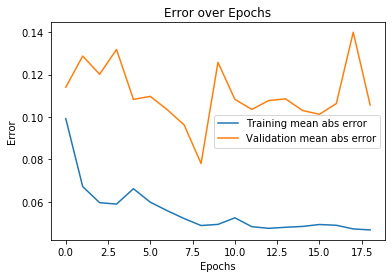

In [167]:
# Plot the training history.
plt.plot(history.history["mae"], label="Training mean abs error")
plt.plot(history.history["val_mae"], label="Validation mean abs error")
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.legend()
plt.title("Error over Epochs")

In [169]:
# Load the best weights.
model.load_weights("lstm_weights.hdf5")

We can see how well our model fits the training data.

Text(0.5, 1.0, 'Training Prediction')

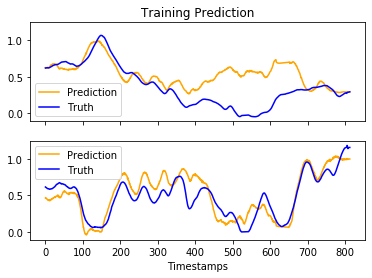

In [175]:
y_hat = model.predict(sampled_train_X, batch_size=1)
fig, axes = plt.subplots(nrows=2, sharex=True, sharey=True)
axes[0].plot(y_hat[:,0], color="orange", label="Prediction")
axes[0].plot(sampled_train_y[:,0], color="blue", label="Truth")
axes[0].legend()
axes[1].plot(y_hat[:,1], color="orange", label="Prediction")
axes[1].plot(sampled_train_y[:,1], color="blue", label="Truth")
axes[1].legend()
axes[1].set_xlabel("Timestamps")
axes[0].set_title("Training Prediction")

And more importantly, we want to see how it performs on our testing data.

Text(0.5, 1.0, 'Training Prediction')

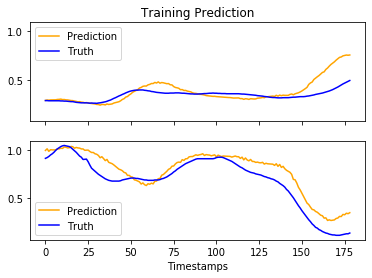

In [176]:
y_hat = model.predict(sampled_test_X, batch_size=1)
fig, axes = plt.subplots(nrows=2, sharex=True, sharey=True)
axes[0].plot(y_hat[:,0], color="orange", label="Prediction")
axes[0].plot(sampled_test_y[:,0], color="blue", label="Truth")
axes[0].legend()
axes[1].plot(y_hat[:,1], color="orange", label="Prediction")
axes[1].plot(sampled_test_y[:,1], color="blue", label="Truth")
axes[1].legend()
axes[1].set_xlabel("Timestamps")
axes[0].set_title("Training Prediction")

We can quantify how good the model did by evaluating it like we did with the naive model.

In [205]:
lstm_evaluation = model.evaluate(sampled_test_X, sampled_test_y, batch_size=1)

179/179 [==============================] - 0s 2ms/step


In [199]:
# We need the scaling factor for just the positions.
position_scaler = minmax_scaler.scale_[:2]

In [206]:
# Both dimensions must be scaled back to normal and summed together.
lstm_evaluation = sum(evaluation / position_scaler)

In [209]:
print("naive_evaluation: ", naive_evaluation)
print("lstm_evaluation: ", lstm_evaluation)
print("lstm_evaluation - naive_evaluation: ", lstm_evaluation-naive_evaluation)

naive_evaluation:  26.746428571428574
lstm_evaluation:  27.42641949798234
lstm_evaluation - naive_evaluation:  0.6799909265537671


We see that the LSTM came close but was still worse then the *extremely* simple persistence method. This gives us strong reason to believe that the underlying process is inherently random in nature and thus harder and harder to forecast the further we go into the future.

## Using Linear Models for Better Analysis

Let's try to learn more about the relationship between the green and red signals. We could try the most simple model possible, a line. Since we saw a nice linear correlation between the respective dimensions of the green and red position, we should be able to use linear regression to determine the functional relationship between their positions, at least in the form f(x) = b + mx.

More formally, we'll build a simple model that maps $\vec{g}$ to $\vec{r}$ in the respective $x$ and $y$ dimensions. But for demonstration purposes, let's just compute it in the $x$ dimension. So in that case,
$$f(x) = b + a g_x$$
  
where $b$ is the y-intercept and $a$ is the coefficient, slope or *weight* of that variable's importance.
  
Then we can use the predicted position of $\vec{r}$ from the regression model to forecast the *future* position of $\vec{r}$. Let's say our output of the regression $f(x)$ is $\hat{r}$ and thus
$$F(\hat{r}) = d + \sum_{t=1}^{n} c_{t}\ f(\hat{r}_{t})$$
  
  where $d$ is the y-intercept and $c_1$ through $c_n$ are the weights for each timestep for the forecast function.

In [368]:
lr_model_x = LinearRegression().fit(cleaned_train_X["green_position_x"].values.reshape(-1, 1), cleaned_train_y["red_position_x"])

In [369]:
x_intercept = lr_model_x.intercept_
x_coef = lr_model_x.coef_
print("Formula for model function (in x dimension) (to 2 sig digs)")
coef_str_list = [f"{coef:.2f}x" for i, coef in enumerate(x_coef)]
print(f"f(x) = {x_intercept:.2f} + {' + '.join(coef_str_list)}")

Formula for model function (in x dimension) (to 2 sig digs)
f(x) = 2.62 + 1.02x


If we can approximate the function of $\vec{r}$ given $\vec{g}$ reasonably well, then it becomes easy to analyze the other kinematic properties using the derivatives:
$$\dot{r} = \frac{d\vec{r}}{dx} = f'(x)$$

In [370]:
print("Velocity of red given position of green (in x dimension) (to 2 sig digs)")
print(f"f'(x) = {x_coef[0]:.2f}")

Velocity of red given position of green (in x dimension) (to 2 sig digs)
f'(x) = 1.02


We can plot how our regression line looks compared to the original scatterplot showing the correlation in the x dimension.

Text(0.5,1,'Regression Line of r_x given g_x')

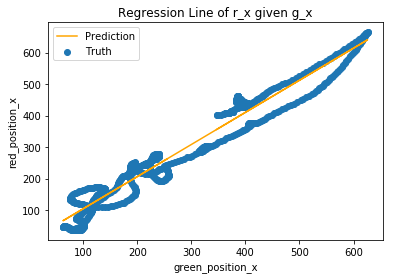

In [375]:
t = cleaned_train_X["green_position_x"]
f_x = lambda t: x_intercept + x_coef[0]*t
plt.scatter(cleaned_train_X["green_position_x"], cleaned_train_y["red_position_x"], label="Truth")
plt.plot(t, f_x(t), color="orange", label="Prediction")
plt.xlabel("green_position_x")
plt.ylabel("red_position_x")
plt.legend()
plt.title("Regression Line of r_x given g_x")

Text(0.5,1,'Training Prediction of r_x given g_x')

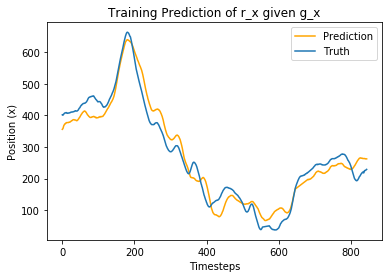

In [376]:
x_prediction = lr_model_x.predict(cleaned_train_X["green_position_x"].values.reshape(-1, 1))
plt.plot(x_prediction, color="orange", label="Prediction")
plt.plot(cleaned_train_y["red_position_x"], label="Truth")
plt.xlabel("Timesteps")
plt.ylabel("Position (x)")
plt.legend()
plt.title("Training Prediction of r_x given g_x")

Text(0.5,1,'Testing Prediction of r_x given g_x')

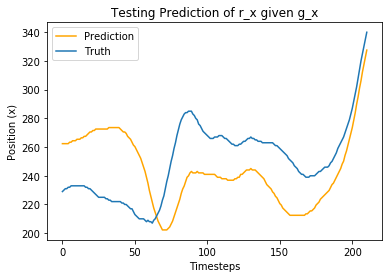

In [377]:
x_prediction = lr_model_x.predict(cleaned_test_X["green_position_x"].values.reshape(-1, 1))
plt.plot(x_prediction, color="orange", label="Prediction")
plt.plot(cleaned_test_y["red_position_x"].values, label="Truth")
plt.xlabel("Timesteps")
plt.ylabel("Position (x)")
plt.legend()
plt.title("Testing Prediction of r_x given g_x")

In [379]:
print("mean_absolute_error:", mean_absolute_error(cleaned_test_y["red_position_x"], x_prediction))

mean_absolute_error: 30.982011188860323


This MAE for *just* the x dimension is more than the error we got using the LSTM or naive model for *both* dimensions. So even though this simple model captures the relationship in a very easy-to-interpret way, it's not as accurate as.
  
We can try using some fancier methods to improve the model's power. We'll use ridge regression to make the model more generalizable and exhaustively search a list of the "penalty" values `alpha` that will regularize the model to find the optimal one.

In [381]:
%%time

ridge_model_x = Ridge()

hyperparameters = {"alpha": np.logspace(-1, 14, num=16, base=2)}

cv = TimeSeriesSplit(n_splits=5)

grid_x = GridSearchCV(ridge_model_x,
                            param_grid=hyperparameters,
                            cv=cv, # We need to use our own train-validation split to preserve the order of the data.
                            n_jobs=-1 # n_jobs=-1 means to use max CPUS.
)

grid_x.fit(cleaned_train_X["green_position_x"].values.reshape(-1, 1), cleaned_train_y["red_position_x"])

CPU times: user 316 ms, sys: 64.4 ms, total: 380 ms
Wall time: 547 ms


In [382]:
print("Best hyperparameter:", grid_x.best_params_)

Best hyperparameter: {'alpha': 0.5}


In [383]:
ridge_model_x = grid_x.best_estimator_

In [384]:
x_intercept = ridge_model_x.intercept_
x_coef = lr_model_x.coef_
print("The new formula")
print(f"f(x) = {x_intercept:.2f} + {x_coef[0]:.2f}x")

The new formula
f(x) = 2.62 + 1.02x


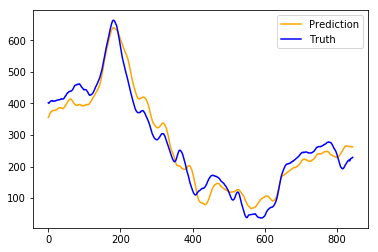

In [385]:
train_prediction_x = ridge_model_x.predict(cleaned_train_X["green_position_x"].values.reshape(-1, 1))
plt.plot(train_prediction_x, color="orange", label="Prediction")
plt.plot(cleaned_train_y["red_position_x"], color="blue", label="Truth")
plt.legend()

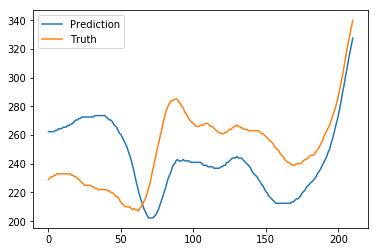

In [386]:
test_prediction_x = ridge_model_x.predict(cleaned_test_X["green_position_x"].values.reshape(-1, 1))
plt.plot(test_prediction_x, label="Prediction")
plt.plot(cleaned_test_y["red_position_x"].values, label="Truth")
plt.legend()

In [393]:
print("mean_absolute_error:", mean_absolute_error(cleaned_test_y["red_position_x"], test_prediction_x))

mean_absolute_error: 30.982010574458826


It appears that the vanilla linear model was already as good as it gets. We'll work with what we've got and try using our regression model's output as the input for our forecasting model.

We're going to measure the utility of our model in a more accurate way. Instead of using the testing input for our prediction, we'll prime our model using `history_timesteps` worth of the last datapoints as if we only that shapshot of the lead's positions to be able to work with. Then we'll iteratively predict the next timestep but *append* that prediction to our input data sample and drop the oldest (smallest index) point from the sample. In the real world, you don't have access to future data while forecasting. So by using "walking forward" using our own predicitions, we can simulate how this model would most likely be used. So we'll repeatedly feed our $n$ timesteps of $\hat{r}$ back into our model $m$ times to forecast $m$ timesteps into the future.
  
We'll need to build our own grid search system to try out different lengths of `history_timesteps` with different values for `alpha` to try to avoid overfitting.

In [394]:
def walking_prediction(model, sample, n_predictions=1):
    # Return list of predictions of length n_predictions given a sklearn model, a sample list, and n_predictions int.
    sample_size = len(sample)
    predictions = []
    for _ in range(n_predictions):
        y_hat = model.predict(np.array(sample).reshape(1, sample_size))[0] # Index of [0] to extract the value.
        predictions.append(y_hat)
        sample.append(y_hat)
        sample = sample[-sample_size:]
    return predictions

In [395]:
def search_custom_grid(X, y, timesteps, alphas, primer_data, test_y, n_predictions=1, verbose=False):
    # Return a dict of the best evaluation, model, predictions and parameters given the unsampled training X and y
    # as well as a list of timesteps and a list alpha values to exhaustively try. The last timesteps worth of primer_data
    # is used to initialize the walking prediction with the current timestep and alpha combo. The prediction of
    # n_predictions size is compared to test_y, the ground truth, and if it's better, then that model and combo replaces
    # the previous best ones. verbose sets whether to print output for each combo or not.
    i = 1
    total_combs = len(timesteps) * len(alphas)
    best_evaluation = 1e3
    best_model = None
    best_walking_train_predictions_x = None
    for history_timesteps in timesteps:
        A, b = sample_X_y(X, y, history_size=history_timesteps)
        for alpha in alphas:
            grid_model = Ridge(alpha=alpha)
            grid_model.fit(A, b)
            predictions = walking_prediction(grid_model,
                                               list(primer_data[-history_timesteps:]),
                                               n_predictions=n_predictions)
            evaluation = mean_absolute_error(test_y, predictions)
            if evaluation < best_evaluation:
                best_evaluation = evaluation
                best_model = grid_model
                best_predictions = predictions
                best_timesteps = history_timesteps
                best_alpha = alpha
            if verbose:
                print(f"#{i} of {total_combs}: {history_timesteps} timesteps with {alpha} alpha: {evaluation} error")
            i += 1
    return {"best_evaluation": best_evaluation,
            "best_model": best_model,
            "best_predictions": best_predictions,
            "best_params": {"timesteps": best_timesteps, "alpha": best_alpha}}

In [396]:
%%time

grid_result = search_custom_grid(train_prediction_x, train_prediction_x,
                    np.linspace(2, 200, 100, dtype=int),
                    np.logspace(-1, 14, num=16, base=2),
                    train_prediction_x,
                    cleaned_test_y["red_position_x"],
                    n_predictions=len(cleaned_test_y),
                    verbose=True)

#1 of 1600: 2 timesteps with 0.5 alpha: 23.280285848383173 error
#2 of 1600: 2 timesteps with 1.0 alpha: 23.2843701079161 error
#3 of 1600: 2 timesteps with 2.0 alpha: 23.292440520850104 error
#4 of 1600: 2 timesteps with 4.0 alpha: 23.308200001953256 error
#5 of 1600: 2 timesteps with 8.0 alpha: 23.338276995652613 error
#6 of 1600: 2 timesteps with 16.0 alpha: 23.393256237432077 error
#7 of 1600: 2 timesteps with 32.0 alpha: 23.493967838493422 error
#8 of 1600: 2 timesteps with 64.0 alpha: 23.658785688740767 error
#9 of 1600: 2 timesteps with 128.0 alpha: 23.886169546457115 error
#10 of 1600: 2 timesteps with 256.0 alpha: 24.137424650562647 error
#11 of 1600: 2 timesteps with 512.0 alpha: 24.370677451497958 error
#12 of 1600: 2 timesteps with 1024.0 alpha: 24.536985258476847 error
#13 of 1600: 2 timesteps with 2048.0 alpha: 24.625685323718006 error
#14 of 1600: 2 timesteps with 4096.0 alpha: 24.650702166968934 error
#15 of 1600: 2 timesteps with 8192.0 alpha: 24.61315356693038 error
#

#126 of 1600: 16 timesteps with 4096.0 alpha: 23.19371789447818 error
#127 of 1600: 16 timesteps with 8192.0 alpha: 23.163249057288905 error
#128 of 1600: 16 timesteps with 16384.0 alpha: 23.15097768475317 error
#129 of 1600: 18 timesteps with 0.5 alpha: 23.804744039508947 error
#130 of 1600: 18 timesteps with 1.0 alpha: 23.802530732284286 error
#131 of 1600: 18 timesteps with 2.0 alpha: 23.79813406794906 error
#132 of 1600: 18 timesteps with 4.0 alpha: 23.7894591682441 error
#133 of 1600: 18 timesteps with 8.0 alpha: 23.772571892173975 error
#134 of 1600: 18 timesteps with 16.0 alpha: 23.741284410215446 error
#135 of 1600: 18 timesteps with 32.0 alpha: 23.68708727063875 error
#136 of 1600: 18 timesteps with 64.0 alpha: 23.601525206786377 error
#137 of 1600: 18 timesteps with 128.0 alpha: 23.487863261722644 error
#138 of 1600: 18 timesteps with 256.0 alpha: 23.374794186849275 error
#139 of 1600: 18 timesteps with 512.0 alpha: 23.299667823030315 error
#140 of 1600: 18 timesteps with 102

#248 of 1600: 32 timesteps with 64.0 alpha: 24.281115454396232 error
#249 of 1600: 32 timesteps with 128.0 alpha: 24.160588167472504 error
#250 of 1600: 32 timesteps with 256.0 alpha: 24.06654130309877 error
#251 of 1600: 32 timesteps with 512.0 alpha: 24.040622024856614 error
#252 of 1600: 32 timesteps with 1024.0 alpha: 24.057691873511033 error
#253 of 1600: 32 timesteps with 2048.0 alpha: 24.150997907517475 error
#254 of 1600: 32 timesteps with 4096.0 alpha: 24.257412439562884 error
#255 of 1600: 32 timesteps with 8192.0 alpha: 24.34367652591643 error
#256 of 1600: 32 timesteps with 16384.0 alpha: 24.424971600117505 error
#257 of 1600: 34 timesteps with 0.5 alpha: 25.31710607247226 error
#258 of 1600: 34 timesteps with 1.0 alpha: 25.305565866632666 error
#259 of 1600: 34 timesteps with 2.0 alpha: 25.282547055100153 error
#260 of 1600: 34 timesteps with 4.0 alpha: 25.236766098952852 error
#261 of 1600: 34 timesteps with 8.0 alpha: 25.14924029700069 error
#262 of 1600: 34 timesteps wi

#371 of 1600: 48 timesteps with 2.0 alpha: 25.044871803010473 error
#372 of 1600: 48 timesteps with 4.0 alpha: 25.026224401763713 error
#373 of 1600: 48 timesteps with 8.0 alpha: 24.98847359103579 error
#374 of 1600: 48 timesteps with 16.0 alpha: 24.910634427141332 error
#375 of 1600: 48 timesteps with 32.0 alpha: 24.767964219401907 error
#376 of 1600: 48 timesteps with 64.0 alpha: 24.57526536586556 error
#377 of 1600: 48 timesteps with 128.0 alpha: 24.39929429119359 error
#378 of 1600: 48 timesteps with 256.0 alpha: 24.383817478690897 error
#379 of 1600: 48 timesteps with 512.0 alpha: 24.423437414403594 error
#380 of 1600: 48 timesteps with 1024.0 alpha: 24.448820873594673 error
#381 of 1600: 48 timesteps with 2048.0 alpha: 24.410129849345875 error
#382 of 1600: 48 timesteps with 4096.0 alpha: 24.319543926754136 error
#383 of 1600: 48 timesteps with 8192.0 alpha: 24.1906779688788 error
#384 of 1600: 48 timesteps with 16384.0 alpha: 24.041388482288294 error
#385 of 1600: 50 timesteps w

#492 of 1600: 62 timesteps with 1024.0 alpha: 23.59770933206471 error
#493 of 1600: 62 timesteps with 2048.0 alpha: 23.535004265105187 error
#494 of 1600: 62 timesteps with 4096.0 alpha: 23.507554719150217 error
#495 of 1600: 62 timesteps with 8192.0 alpha: 23.53314911478339 error
#496 of 1600: 62 timesteps with 16384.0 alpha: 23.626994777164715 error
#497 of 1600: 64 timesteps with 0.5 alpha: 27.170122768127523 error
#498 of 1600: 64 timesteps with 1.0 alpha: 27.167445027383312 error
#499 of 1600: 64 timesteps with 2.0 alpha: 27.161517826167877 error
#500 of 1600: 64 timesteps with 4.0 alpha: 27.1475400815774 error
#501 of 1600: 64 timesteps with 8.0 alpha: 27.112247063548175 error
#502 of 1600: 64 timesteps with 16.0 alpha: 27.01961932917226 error
#503 of 1600: 64 timesteps with 32.0 alpha: 26.78421971992148 error
#504 of 1600: 64 timesteps with 64.0 alpha: 26.256389711539974 error
#505 of 1600: 64 timesteps with 128.0 alpha: 25.31874591846805 error
#506 of 1600: 64 timesteps with 25

#613 of 1600: 78 timesteps with 8.0 alpha: 26.996274726435473 error
#614 of 1600: 78 timesteps with 16.0 alpha: 26.795541525590036 error
#615 of 1600: 78 timesteps with 32.0 alpha: 26.41116604971689 error
#616 of 1600: 78 timesteps with 64.0 alpha: 25.75927210265062 error
#617 of 1600: 78 timesteps with 128.0 alpha: 24.97124036521862 error
#618 of 1600: 78 timesteps with 256.0 alpha: 24.36185646977786 error
#619 of 1600: 78 timesteps with 512.0 alpha: 24.18505682376625 error
#620 of 1600: 78 timesteps with 1024.0 alpha: 24.19567063850835 error
#621 of 1600: 78 timesteps with 2048.0 alpha: 24.164732393316655 error
#622 of 1600: 78 timesteps with 4096.0 alpha: 24.04243317722433 error
#623 of 1600: 78 timesteps with 8192.0 alpha: 23.844596938810085 error
#624 of 1600: 78 timesteps with 16384.0 alpha: 23.587382846823136 error
#625 of 1600: 80 timesteps with 0.5 alpha: 25.953649168133108 error
#626 of 1600: 80 timesteps with 1.0 alpha: 25.948765568032947 error
#627 of 1600: 80 timesteps wit

#741 of 1600: 94 timesteps with 8.0 alpha: 29.551860305890617 error
#742 of 1600: 94 timesteps with 16.0 alpha: 29.40963186251296 error
#743 of 1600: 94 timesteps with 32.0 alpha: 29.063938895247755 error
#744 of 1600: 94 timesteps with 64.0 alpha: 28.35231839708181 error
#745 of 1600: 94 timesteps with 128.0 alpha: 27.163189855385966 error
#746 of 1600: 94 timesteps with 256.0 alpha: 25.657678757489943 error
#747 of 1600: 94 timesteps with 512.0 alpha: 24.32015715453233 error
#748 of 1600: 94 timesteps with 1024.0 alpha: 23.65912508699955 error
#749 of 1600: 94 timesteps with 2048.0 alpha: 23.46768402521607 error
#750 of 1600: 94 timesteps with 4096.0 alpha: 23.45249129529455 error
#751 of 1600: 94 timesteps with 8192.0 alpha: 23.54209908535542 error
#752 of 1600: 94 timesteps with 16384.0 alpha: 23.75459474108456 error
#753 of 1600: 96 timesteps with 0.5 alpha: 28.108969362527084 error
#754 of 1600: 96 timesteps with 1.0 alpha: 28.11042875751478 error
#755 of 1600: 96 timesteps with 

#869 of 1600: 110 timesteps with 8.0 alpha: 27.60132065972482 error
#870 of 1600: 110 timesteps with 16.0 alpha: 27.40427452628681 error
#871 of 1600: 110 timesteps with 32.0 alpha: 26.982428040308555 error
#872 of 1600: 110 timesteps with 64.0 alpha: 26.20206537291565 error
#873 of 1600: 110 timesteps with 128.0 alpha: 25.16391897275486 error
#874 of 1600: 110 timesteps with 256.0 alpha: 24.33616639494537 error
#875 of 1600: 110 timesteps with 512.0 alpha: 24.040053199918702 error
#876 of 1600: 110 timesteps with 1024.0 alpha: 24.01966445590077 error
#877 of 1600: 110 timesteps with 2048.0 alpha: 24.04625911727132 error
#878 of 1600: 110 timesteps with 4096.0 alpha: 24.05562165582894 error
#879 of 1600: 110 timesteps with 8192.0 alpha: 24.05024884538839 error
#880 of 1600: 110 timesteps with 16384.0 alpha: 24.034424303789795 error
#881 of 1600: 112 timesteps with 0.5 alpha: 28.87048180989059 error
#882 of 1600: 112 timesteps with 1.0 alpha: 28.865276297378134 error
#883 of 1600: 112 t

#988 of 1600: 124 timesteps with 1024.0 alpha: 25.29325802931108 error
#989 of 1600: 124 timesteps with 2048.0 alpha: 24.893271005008433 error
#990 of 1600: 124 timesteps with 4096.0 alpha: 24.675377168524335 error
#991 of 1600: 124 timesteps with 8192.0 alpha: 24.45297144573716 error
#992 of 1600: 124 timesteps with 16384.0 alpha: 24.262715330289257 error
#993 of 1600: 126 timesteps with 0.5 alpha: 31.69776885488191 error
#994 of 1600: 126 timesteps with 1.0 alpha: 31.693237203457628 error
#995 of 1600: 126 timesteps with 2.0 alpha: 31.682370189627953 error
#996 of 1600: 126 timesteps with 4.0 alpha: 31.654337681182227 error
#997 of 1600: 126 timesteps with 8.0 alpha: 31.579945496752238 error
#998 of 1600: 126 timesteps with 16.0 alpha: 31.38723752256234 error
#999 of 1600: 126 timesteps with 32.0 alpha: 30.935989416681192 error
#1000 of 1600: 126 timesteps with 64.0 alpha: 30.071299737804065 error
#1001 of 1600: 126 timesteps with 128.0 alpha: 28.777813127791923 error
#1002 of 1600: 

#1104 of 1600: 138 timesteps with 16384.0 alpha: 24.68767361211164 error
#1105 of 1600: 140 timesteps with 0.5 alpha: 28.72414588854452 error
#1106 of 1600: 140 timesteps with 1.0 alpha: 28.719004970976155 error
#1107 of 1600: 140 timesteps with 2.0 alpha: 28.70781076869854 error
#1108 of 1600: 140 timesteps with 4.0 alpha: 28.682203652993028 error
#1109 of 1600: 140 timesteps with 8.0 alpha: 28.62088819129243 error
#1110 of 1600: 140 timesteps with 16.0 alpha: 28.473367131424144 error
#1111 of 1600: 140 timesteps with 32.0 alpha: 28.140444011756138 error
#1112 of 1600: 140 timesteps with 64.0 alpha: 27.502382799330874 error
#1113 of 1600: 140 timesteps with 128.0 alpha: 26.639491534404424 error
#1114 of 1600: 140 timesteps with 256.0 alpha: 25.822449284994445 error
#1115 of 1600: 140 timesteps with 512.0 alpha: 25.344184497201397 error
#1116 of 1600: 140 timesteps with 1024.0 alpha: 25.11135935438286 error
#1117 of 1600: 140 timesteps with 2048.0 alpha: 25.04884854281495 error
#1118 o

#1226 of 1600: 154 timesteps with 256.0 alpha: 33.411966981934846 error
#1227 of 1600: 154 timesteps with 512.0 alpha: 33.59629667558971 error
#1228 of 1600: 154 timesteps with 1024.0 alpha: 33.64451470461491 error
#1229 of 1600: 154 timesteps with 2048.0 alpha: 33.57285647222186 error
#1230 of 1600: 154 timesteps with 4096.0 alpha: 33.41105173953964 error
#1231 of 1600: 154 timesteps with 8192.0 alpha: 33.17618400086662 error
#1232 of 1600: 154 timesteps with 16384.0 alpha: 32.9162093090606 error
#1233 of 1600: 156 timesteps with 0.5 alpha: 33.70856155386469 error
#1234 of 1600: 156 timesteps with 1.0 alpha: 33.70352258544498 error
#1235 of 1600: 156 timesteps with 2.0 alpha: 33.69437387977839 error
#1236 of 1600: 156 timesteps with 4.0 alpha: 33.67945823340527 error
#1237 of 1600: 156 timesteps with 8.0 alpha: 33.66085756142813 error
#1238 of 1600: 156 timesteps with 16.0 alpha: 33.655018044125576 error
#1239 of 1600: 156 timesteps with 32.0 alpha: 33.706985716662736 error
#1240 of 1

#1344 of 1600: 168 timesteps with 16384.0 alpha: 37.97276523737727 error
#1345 of 1600: 170 timesteps with 0.5 alpha: 37.74186705340068 error
#1346 of 1600: 170 timesteps with 1.0 alpha: 37.736154886425815 error
#1347 of 1600: 170 timesteps with 2.0 alpha: 37.72580432747776 error
#1348 of 1600: 170 timesteps with 4.0 alpha: 37.7088703349023 error
#1349 of 1600: 170 timesteps with 8.0 alpha: 37.686780504035745 error
#1350 of 1600: 170 timesteps with 16.0 alpha: 37.672781543091055 error
#1351 of 1600: 170 timesteps with 32.0 alpha: 37.700264600370396 error
#1352 of 1600: 170 timesteps with 64.0 alpha: 37.80914032840571 error
#1353 of 1600: 170 timesteps with 128.0 alpha: 37.99866876962881 error
#1354 of 1600: 170 timesteps with 256.0 alpha: 38.19272423704025 error
#1355 of 1600: 170 timesteps with 512.0 alpha: 38.28344586672193 error
#1356 of 1600: 170 timesteps with 1024.0 alpha: 38.24506235825922 error
#1357 of 1600: 170 timesteps with 2048.0 alpha: 38.15939171674488 error
#1358 of 160

#1465 of 1600: 184 timesteps with 128.0 alpha: 38.71639879240065 error
#1466 of 1600: 184 timesteps with 256.0 alpha: 39.02616585926878 error
#1467 of 1600: 184 timesteps with 512.0 alpha: 39.372853141296574 error
#1468 of 1600: 184 timesteps with 1024.0 alpha: 39.65382487348571 error
#1469 of 1600: 184 timesteps with 2048.0 alpha: 39.843556291611534 error
#1470 of 1600: 184 timesteps with 4096.0 alpha: 39.99499772013263 error
#1471 of 1600: 184 timesteps with 8192.0 alpha: 40.15322990323602 error
#1472 of 1600: 184 timesteps with 16384.0 alpha: 40.347901881004105 error
#1473 of 1600: 186 timesteps with 0.5 alpha: 38.204577019298085 error
#1474 of 1600: 186 timesteps with 1.0 alpha: 38.20465608529333 error
#1475 of 1600: 186 timesteps with 2.0 alpha: 38.20507921569207 error
#1476 of 1600: 186 timesteps with 4.0 alpha: 38.20682938622807 error
#1477 of 1600: 186 timesteps with 8.0 alpha: 38.21302391922946 error
#1478 of 1600: 186 timesteps with 16.0 alpha: 38.23180505333227 error
#1479 o

#1585 of 1600: 200 timesteps with 0.5 alpha: 37.42619283308749 error
#1586 of 1600: 200 timesteps with 1.0 alpha: 37.424278428856766 error
#1587 of 1600: 200 timesteps with 2.0 alpha: 37.42098313566351 error
#1588 of 1600: 200 timesteps with 4.0 alpha: 37.41627905746773 error
#1589 of 1600: 200 timesteps with 8.0 alpha: 37.41285827170331 error
#1590 of 1600: 200 timesteps with 16.0 alpha: 37.42178990821094 error
#1591 of 1600: 200 timesteps with 32.0 alpha: 37.469995441563086 error
#1592 of 1600: 200 timesteps with 64.0 alpha: 37.596552561720834 error
#1593 of 1600: 200 timesteps with 128.0 alpha: 37.819336481035954 error
#1594 of 1600: 200 timesteps with 256.0 alpha: 38.09520119945746 error
#1595 of 1600: 200 timesteps with 512.0 alpha: 38.34844942000553 error
#1596 of 1600: 200 timesteps with 1024.0 alpha: 38.51884109094334 error
#1597 of 1600: 200 timesteps with 2048.0 alpha: 38.631020601013724 error
#1598 of 1600: 200 timesteps with 4096.0 alpha: 38.76516542211422 error
#1599 of 16

In [397]:
print("Best evaluation:", grid_result["best_evaluation"])
print("Best timesteps:", grid_result["best_params"]["timesteps"])
print("Best alpha:", grid_result["best_params"]["alpha"])
ridge_model_x = grid_result["best_model"]

Best evaluation: 22.890435851729947
Best timesteps: 70
Best alpha: 16384.0


After finding the ideal combo of input timestep size and `alpha` regularization, we'll plot the best model's walking prediction $F(\hat{r})$ compared to the true data for $\vec{g}_x$ and $\vec{r}_x$ as well as our regression prediction $\hat{r}$.

Text(0,0.5,'Position (x)')

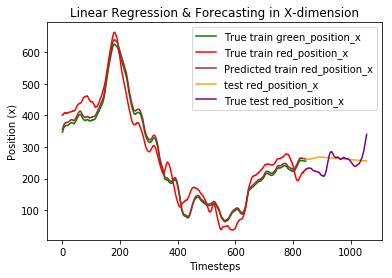

In [398]:
plt.plot(cleaned_train_X["green_position_x"], color="green", label="True train green_position_x")
plt.plot(cleaned_train_y["red_position_x"], color="red", label="True train red_position_x")
plt.plot(train_prediction_x, color="brown", label="Predicted train red_position_x")
plt.plot(cleaned_test_y.index, grid_result["best_predictions"], color="orange", label="test red_position_x")
plt.plot(cleaned_test_y["red_position_x"], color="purple", label="True test red_position_x")
plt.legend()
plt.title("Linear Regression & Forecasting in X-dimension")
plt.xlabel("Timesteps")
plt.ylabel("Position (x)")

Unfortunately, the two models together appear to miss the upward trend of the true test set. This is probably because it is apparently overfitting to the lead's movement too much to be able to generalize to the follow's side to side change near the end of routine. If we could improve the regression step, we may be able to improve the forecasting step. Feature engineering our input training data could help. A possibility would be to modify the target data for $\vec{r}$ to be the relative position compared to $\vec{g}$, such as
$$\vec{r}_{new} := \vec{r}_{old} - \vec{g}$$
  
This might better capture the true relationship between the lead and follow's movements.

At least we have a (relatively) simple model which could be further analyzed to draw insights. Using a linear relationship against all the input timesteps of the regression model's prediction, we have

$$F(\hat{r}) = d + \sum_{t=1}^{n} c_{t}\ f(\hat{r}_{t})$$
  
where $d$ is the y-intercept and $c_1$ through $c_n$ are the weights for each timestep for the forecast function.

In [399]:
x_intercept = ridge_model_x.intercept_
x_coefs = ridge_model_x.coef_
print("Formula for model function (to 2 sig digs)")
coef_str_list = [f"{coef:.2f}x_{i}" for i, coef in enumerate(x_coefs)]
print(f"F(x_t ... x_t+m) = {x_intercept:.2f} + {' + '.join(coef_str_list)}")

Formula for model function (to 2 sig digs)
F(x_t ... x_t+m) = 0.56 + 0.01x_0 + 0.00x_1 + 0.00x_2 + -0.00x_3 + -0.00x_4 + -0.01x_5 + -0.01x_6 + -0.01x_7 + -0.00x_8 + -0.00x_9 + -0.00x_10 + -0.00x_11 + 0.00x_12 + 0.00x_13 + 0.00x_14 + 0.00x_15 + 0.00x_16 + 0.00x_17 + 0.00x_18 + 0.00x_19 + 0.00x_20 + -0.00x_21 + -0.00x_22 + -0.00x_23 + -0.00x_24 + -0.00x_25 + -0.00x_26 + -0.00x_27 + -0.00x_28 + -0.00x_29 + -0.00x_30 + -0.00x_31 + -0.00x_32 + -0.00x_33 + -0.00x_34 + -0.00x_35 + 0.00x_36 + 0.00x_37 + 0.00x_38 + 0.00x_39 + 0.01x_40 + 0.01x_41 + 0.01x_42 + 0.00x_43 + 0.00x_44 + 0.00x_45 + 0.00x_46 + 0.00x_47 + 0.00x_48 + 0.00x_49 + 0.00x_50 + 0.00x_51 + 0.00x_52 + -0.00x_53 + -0.01x_54 + -0.01x_55 + -0.02x_56 + -0.03x_57 + -0.04x_58 + -0.05x_59 + -0.05x_60 + -0.05x_61 + -0.04x_62 + -0.02x_63 + 0.02x_64 + 0.07x_65 + 0.14x_66 + 0.23x_67 + 0.34x_68 + 0.46x_69


Text(0.5,1,'Strengths of Weights')

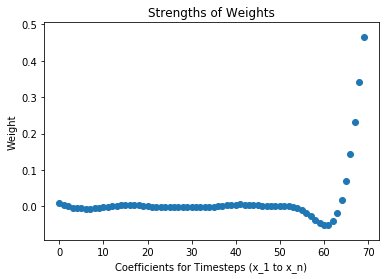

In [409]:
plt.scatter(np.arange(len(x_coefs)), x_coefs)
plt.xlabel("Coefficients for Timesteps (x_1 to x_n)")
plt.ylabel("Weight")
plt.title("Strengths of Weights")

We can see that the model decided to give the most importance to recent timesteps and almost none to the majorit of the older ones. It's interesting that it also thought that a few timesteps after the most important ones actually have slight negative correlation.

In conclusion, there are many different varities of models and modifications to try. But often 80% of the change in outcome will come from 20% of the change of the set up. Changing the features of the original data to something that is more aligned to the physical process generating the data would probably have far more impact than trying many different algorithms. But this requires domain knowledge of the problem itself. Having more data would also be very helpful, especially for the LSTM since neural networks often need orders of magnitude more datapoints than the number of their trainable parameters in order to be really effective.
  
Considering how effective the naive method was, this could also mean that there's too much uncertainty in the real-world process itself to forecast the future in any reliable way. Although the idea of modelling and forecasting the movement of one a following dancer given their lead is still intriguing. And it could be possible to do given the right quantity and features for the data.